In [1]:
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import seaborn as sns
import keras 
import datetime
import requests
import warnings
import keras

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError

from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from pmdarima import auto_arima

import prophet

warnings.filterwarnings('ignore')

2024-03-12 15:33:34.477096: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/ChloeSokol/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Failed Attempts

## 1

In [3]:
df = pd.read_csv('multivar.csv')
df = df.drop(columns=['iso_code'])
df = df.drop('Unnamed: 0', axis=1)
df = df.set_index('date')
df.index = pd.to_datetime(df.index)
categorical_cols = ['continent', 'tests_units', 'season', 'location']
df = pd.get_dummies(df, columns=categorical_cols)
df = df.sort_index()
df

total_cases  new_cases  new_deaths  total_cases_per_million  \
date                                                                      
2020-03-01          1.0        0.0         0.0                    0.086   
2020-03-01         16.0        0.0         0.0                    0.248   
2020-03-01          NaN        0.0         0.0                      NaN   
2020-03-01          NaN        0.0         0.0                      NaN   
2020-03-01         15.0        5.0         0.0                    1.587   
...                 ...        ...         ...                      ...   
2024-01-07    4848745.0        0.0         0.0               415989.793   
2024-01-07  103436829.0        NaN         0.0               305763.910   
2024-01-14          NaN        NaN         0.0                      NaN   
2024-01-14          NaN        NaN         0.0                      NaN   
2024-01-14          NaN        NaN         1.0                      NaN   

            new_cases_per_million  icu_patients_per_million  \
date                                                          
2020-03-01                  0.000                       NaN   
2020-03-01                  0.000                       NaN   
2020-03-01                  0.000                       NaN   
2020-03-01                  0.000                     0.000   
2020-03-01                  0.529                       NaN   
...                           ...                       ...   
2024-01-07                  0.000                       NaN   
2024-01-07                    NaN                       NaN   
2024-01-14                    NaN                       NaN   
2024-01-14                    NaN                     2.287   
2024-01-14                    NaN                     0.884   

            hosp_patients_per_million  weekly_icu_admissions_per_million  \
date                                                                       
2020-03-01                        NaN                                NaN   
2020-03-01                        NaN                                NaN   
2020-03-01                        NaN                              0.395   
2020-03-01                        NaN                                NaN   
2020-03-01                        NaN                                NaN   
...                               ...                                ...   
2024-01-07                        NaN                                NaN   
2024-01-07                        NaN                                NaN   
2024-01-14                        NaN                                NaN   
2024-01-14                     22.870                                NaN   
2024-01-14                     14.644                                NaN   

            weekly_hosp_admissions_per_million  new_vaccinations  ...  \
date                                                              ...   
2020-03-01                                 NaN               NaN  ...   
2020-03-01                                 NaN               NaN  ...   
2020-03-01                               2.372               NaN  ...   
2020-03-01                                 NaN               NaN  ...   
2020-03-01                                 NaN               NaN  ...   
...                                        ...               ...  ...   
2024-01-07                                 NaN               NaN  ...   
2024-01-07                                 NaN               NaN  ...   
2024-01-14                                 NaN               NaN  ...   
2024-01-14                                 NaN               NaN  ...   
2024-01-14                              34.946              55.0  ...   

            location_Belgium  location_Chile  location_Czechia  \
date                                                             
2020-03-01                 1               0                 0   
2020-03-01                 0               0                 0   
2020-03-01   

In [4]:
def process(df):
    lag1df = df.shift(1)
    lag1df.columns = ['lag1_' + str(col) for col in lag1df.columns]
    df=df[['new_deaths']].join(lag1df)
    return df.fillna(0) 
def normalize(df):
    for col in df.columns:
        if col != 'new_deaths':
            df[col]=(df[col]-df[col].mean())/df[col].std()
    return df 

In [5]:
df=process(df)
df=normalize(df)
df.shape

(20209, 68)

In [6]:
grouped = df.groupby('date')
sequences = []
targets = []


for _, group in grouped:
    deaths = group['new_deaths'].values
    for i in range(len(deaths) - 13):
        sequences.append(deaths[i:i+13])
        targets.append(deaths[i+13])

sequences = np.array(sequences)
targets = np.array(targets)

In [7]:
X_train_val, X_test, y_train_val, y_test = train_test_split(sequences, targets, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42) 

X_train = np.reshape(X_train, (X_train.shape[0], 13, 1))
X_val = np.reshape(X_val, (X_val.shape[0], 13, 1))
X_test = np.reshape(X_test, (X_test.shape[0], 13, 1))

In [8]:
learning_rate = 0.01
batch_size = 32
epochs = 100
sequence_length =13

In [9]:
inputs = keras.layers.Input(shape=(13,1))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mae")
model.summary()

2024-03-07 13:02:24.943852: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = model.fit(
    x=X_train, y=y_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_data=(X_val, y_val))


Epoch 1/100
330/330 [==============================] - 12s 17ms/step - loss: 837.0373 - val_loss: 781.4502
Epoch 2/100
330/330 [==============================] - 4s 11ms/step - loss: 808.3300 - val_loss: 759.2367
Epoch 3/100
330/330 [==============================] - 5s 16ms/step - loss: 786.2673 - val_loss: 738.5192
Epoch 4/100
330/330 [==============================] - 4s 12ms/step - loss: 767.3349 - val_loss: 722.4079
Epoch 5/100
330/330 [==============================] - 4s 13ms/step - loss: 751.9047 - val_loss: 708.4913
Epoch 6/100
330/330 [==============================] - 4s 12ms/step - loss: 735.2761 - val_loss: 692.7084
Epoch 7/100
330/330 [==============================] - 5s 14ms/step - loss: 721.1561 - val_loss: 678.9679
Epoch 8/100
330/330 [==============================] - 5s 15ms/step - loss: 707.5049 - val_loss: 666.4419
Epoch 9/100
330/330 [==============================] - 6s 17ms/step - loss: 695.0566 - val_loss: 657.3184
Epoch 10/100
330/330 [=======================

In [77]:
plt.figure(figsize=(10, 6))
plt.plot(y_train, label='Actual')
plt.plot(train_pred, label='Predicted')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

2024-03-11 13:22:49.672153: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at transpose_op.cc:142 : INVALID_ARGUMENT: transpose expects a vector of size 2. But input(1) is a vector of size 3


InvalidArgumentError: Graph execution error:

transpose expects a vector of size 2. But input(1) is a vector of size 3
	 [[{{node transpose}}]]
	 [[model_87/lstm_87/PartitionedCall]] [Op:__inference_predict_function_673930]

In [13]:
test_pred = model.predict(X_test)


110/110 [==============================] - 0s 3ms/step


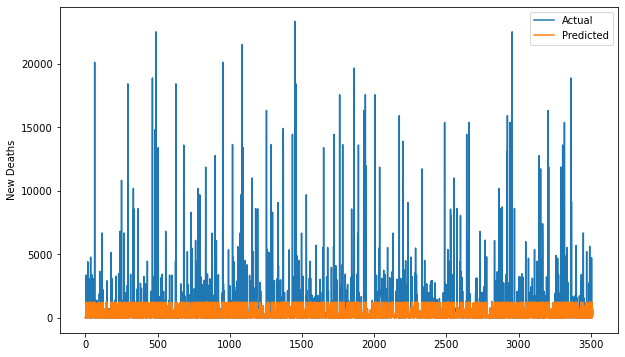

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(test_pred, label='Predicted')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

In [14]:
mase = MeanAbsoluteScaledError(sp = 13)
mase = mase(test_pred, y_test, y_train = y_train)

In [15]:
mase

0.3548758955483503

## 2

In [29]:
df = pd.read_csv('multivar.csv')
df = df.drop(columns=['iso_code'])
df = df.drop('Unnamed: 0', axis=1)
df = df.set_index('date')
df.index = pd.to_datetime(df.index)
categorical_cols = ['continent', 'tests_units', 'season']
df = pd.get_dummies(df, columns=categorical_cols)
df = df.sort_index()
df

location  total_cases  new_cases  new_deaths  \
date                                                            
2020-03-01        Belgium          1.0        0.0         0.0   
2020-03-01         France         16.0        0.0         0.0   
2020-03-01        Ireland          NaN        0.0         0.0   
2020-03-01        Czechia          NaN        0.0         0.0   
2020-03-01         Israel         15.0        5.0         0.0   
...                   ...          ...        ...         ...   
2024-01-07        Belgium    4848745.0        0.0         0.0   
2024-01-07  United States  103436829.0        NaN         0.0   
2024-01-14        Estonia          NaN        NaN         0.0   
2024-01-14        Czechia          NaN        NaN         0.0   
2024-01-14       Malaysia          NaN        NaN         1.0   

            total_cases_per_million  new_cases_per_million  \
date                                                         
2020-03-01                    0.086                  0.000   
2020-03-01                    0.248                  0.000   
2020-03-01                      NaN                  0.000   
2020-03-01                      NaN                  0.000   
2020-03-01                    1.587                  0.529   
...                             ...                    ...   
2024-01-07               415989.793                  0.000   
2024-01-07               305763.910                    NaN   
2024-01-14                      NaN                    NaN   
2024-01-14                      NaN                    NaN   
2024-01-14                      NaN                    NaN   

            icu_patients_per_million  hosp_patients_per_million  \
date                                                              
2020-03-01                       NaN                        NaN   
2020-03-01                       NaN                        NaN   
2020-03-01                       NaN                        NaN   
2020-03-01                     0.000                        NaN   
2020-03-01                       NaN                        NaN   
...                              ...                        ...   
2024-01-07                       NaN                        NaN   
2024-01-07                       NaN                        NaN   
2024-01-14                       NaN                        NaN   
2024-01-14                     2.287                     22.870   
2024-01-14                     0.884                     14.644   

            weekly_icu_admissions_per_million  \
date                                            
2020-03-01                                NaN   
2020-03-01                                NaN   
2020-03-01                              0.395   
2020-03-01                                NaN   
2020-03-01                                NaN   
...                                       ...   
2024-01-07                                NaN   
2024-01-07                                NaN   
2024-01-14                                NaN   
2024-01-14                                NaN   
2024-01-14                                NaN   

            weekly_hosp_admissions_per_million  ...  continent_Asia  \
date                                            ...                   
2020-03-01                                 NaN  ...               0   
2020-03-01                                 NaN  ...               0   
2020-03-01                               2.372  ...               0   
2020-03-01                                 NaN  ...               0   
2020-03-01                                 NaN  ...               1   
...                                        ...  ...             ...   
2024-01-07                                 NaN  ...               0   
2024-01-07                                 NaN  ...               0   
2024-01-14                                 NaN  ...               0   
2024-01-14                                 NaN  ...               0   
20

In [27]:
df[['new_deaths']]

new_deaths
date                  
2020-03-01         0.0
2020-03-01         0.0
2020-03-01         0.0
2020-03-01         0.0
2020-03-01         0.0
...                ...
2024-01-14         0.0
2024-01-14         0.0
2024-01-14         1.0
2024-01-14         1.0
2024-01-14         1.0

[20209 rows x 1 columns]

In [32]:
def process(df):
    locations = df['location']
    lag1df = df.drop(columns=['location']).shift(1)
    lag1df.columns = ['lag1_' + str(col) for col in lag1df.columns]
    lag1df['location'] = locations
    cols = lag1df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    lag1df = lag1df[cols]
    df = df[['new_deaths']].join(lag1df)
    
    return df.fillna(0)

def normalize(df):
    for col in df.columns:
        if col != 'new_deaths' and col != 'location':
            df[col] = (df[col] - df[col].mean()) / df[col].std()
    return df

In [33]:
df=process(df)
df=normalize(df)
df.shape

(20209, 59)

In [34]:
country_groups = df.groupby('location')

sorted_data = {}
for country, data in country_groups:
    sorted_data[country] = data.sort_values('date')

sequence_length = 13
sequences = []
targets = []
for country, data in sorted_data.items():
    for i in range(len(data) - sequence_length):
        sequences.append(data['new_deaths'].values[i:i+sequence_length])
        targets.append(data['new_deaths'].values[i+sequence_length])

sequences = np.array(sequences)
targets = np.array(targets)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(sequences, targets, test_size=0.2, random_state=42)

In [36]:
learning_rate = 0.01
batch_size = 32
epochs = 100
sequence_length =13

In [37]:
inputs = keras.layers.Input(shape=(13, 1))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mae")
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 13, 1)]           0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                4352      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [39]:
model.fit(X_train.reshape((-1, sequence_length, 1)), y_train, 
          epochs=epochs, 
          batch_size=batch_size, 
          validation_split=0.1)


Epoch 1/100
452/452 [==============================] - 7s 17ms/step - loss: 845.9655 - val_loss: 741.9638
Epoch 2/100
452/452 [==============================] - 7s 15ms/step - loss: 845.2639 - val_loss: 741.9826
Epoch 3/100
452/452 [==============================] - 8s 18ms/step - loss: 845.1136 - val_loss: 741.4998
Epoch 4/100
452/452 [==============================] - 7s 16ms/step - loss: 844.2026 - val_loss: 739.9973
Epoch 5/100
452/452 [==============================] - 8s 17ms/step - loss: 843.3309 - val_loss: 741.7485
Epoch 6/100
452/452 [==============================] - 9s 20ms/step - loss: 844.8558 - val_loss: 740.6425
Epoch 7/100
452/452 [==============================] - 10s 21ms/step - loss: 844.6775 - val_loss: 740.8239
Epoch 8/100
452/452 [==============================] - 9s 21ms/step - loss: 843.8878 - val_loss: 739.9153
Epoch 9/100
452/452 [==============================] - 9s 20ms/step - loss: 843.2610 - val_loss: 740.2830
Epoch 10/100
452/452 [=======================

In [40]:
predictions = model.predict(X_test.reshape((-1, sequence_length, 1)))

mase = MeanAbsoluteScaledError(sp = 13)
mase = mase(y_test, predictions, y_train = y_train)

126/126 [==============================] - 1s 3ms/step


In [41]:
mase

0.5450183871077023

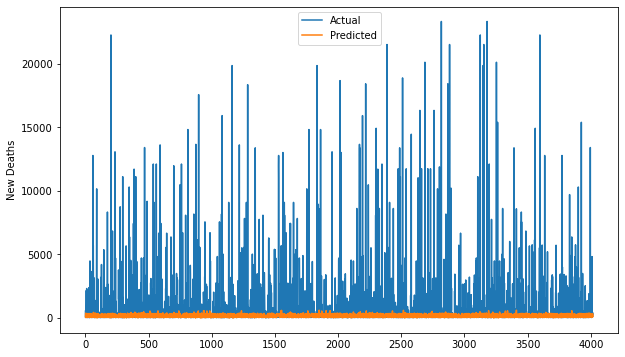

In [42]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

## 3

In [44]:
df = pd.read_csv('multivar.csv')
df = df.drop(columns=['iso_code'])
df = df.drop('Unnamed: 0', axis=1)
df = df.set_index('date')
df.index = pd.to_datetime(df.index)
categorical_cols = ['continent', 'tests_units', 'season']
df = pd.get_dummies(df, columns=categorical_cols)
df = df.sort_index()

In [46]:
def process(df):
    locations = df['location']
    lag1df = df.drop(columns=['location']).shift(1)
    lag1df.columns = ['lag1_' + str(col) for col in lag1df.columns]
    lag1df['location'] = locations
    cols = lag1df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    lag1df = lag1df[cols]
    df = df[['new_deaths']].join(lag1df)
    
    return df.fillna(0)

df = process(df)

In [48]:
grouped = df.groupby('location')
sequences = []
targets = []


for _, group in grouped:
    deaths = group['new_deaths'].values
    for i in range(len(deaths) - 13):
        sequences.append(deaths[i:i+13])
        targets.append(deaths[i+13])

sequences = np.array(sequences)
targets = np.array(targets)

In [49]:
X_train_val, X_test, y_train_val, y_test = train_test_split(sequences, targets, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42) 

X_train = np.reshape(X_train, (X_train.shape[0], 13, 1))
X_val = np.reshape(X_val, (X_val.shape[0], 13, 1))
X_test = np.reshape(X_test, (X_test.shape[0], 13, 1))

In [55]:
X_train_reshaped = X_train.reshape((X_train.shape[0], -1))
X_test_reshaped = X_test.reshape((X_test.shape[0], -1))

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

X_train_scaled = X_train_scaled.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_scaled = X_test_scaled.reshape((X_test.shape[0], X_test.shape[1], 1))

In [59]:
X_val_scaled = scaler.transform(X_val.reshape((X_val.shape[0], -1)))

X_val_scaled = X_val_scaled.reshape((X_val.shape[0], X_val.shape[1], 1))

In [56]:
learning_rate = 0.01
batch_size = 32
epochs = 100
sequence_length =13

In [57]:
inputs = keras.layers.Input(shape=(13,1))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mae")
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 13, 1)]           0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                4352      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [60]:
history = model.fit(
    x=X_train_scaled, y=y_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_data=(X_val_scaled, y_val))

Epoch 1/100
377/377 [==============================] - 9s 11ms/step - loss: 855.6391 - val_loss: 813.6252
Epoch 2/100
377/377 [==============================] - 5s 13ms/step - loss: 852.1760 - val_loss: 813.7153
Epoch 3/100
377/377 [==============================] - 6s 16ms/step - loss: 852.1628 - val_loss: 813.6745
Epoch 4/100
377/377 [==============================] - 7s 19ms/step - loss: 852.1626 - val_loss: 813.7756
Epoch 5/100
377/377 [==============================] - 5s 13ms/step - loss: 852.1577 - val_loss: 813.7692
Epoch 6/100
377/377 [==============================] - 7s 17ms/step - loss: 852.1639 - val_loss: 813.7750
Epoch 7/100
377/377 [==============================] - 8s 23ms/step - loss: 852.1568 - val_loss: 813.6627
Epoch 8/100
377/377 [==============================] - 7s 19ms/step - loss: 852.1601 - val_loss: 813.6934
Epoch 9/100
377/377 [==============================] - 9s 23ms/step - loss: 852.1644 - val_loss: 813.6856
Epoch 10/100
377/377 [========================

377/377 [==============================] - 2s 3ms/step


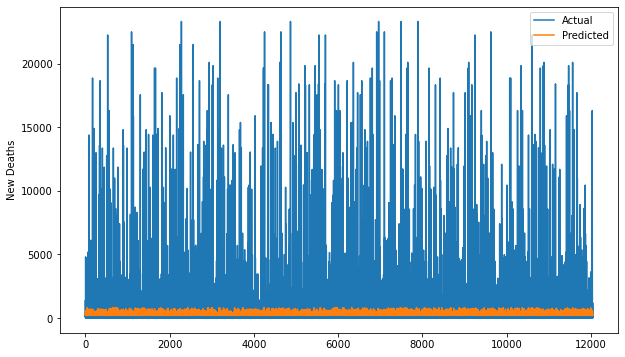

In [61]:
train_pred = model.predict(X_train)
plt.figure(figsize=(10, 6))
plt.plot(y_train, label='Actual')
plt.plot(train_pred, label='Predicted')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

126/126 [==============================] - 0s 2ms/step


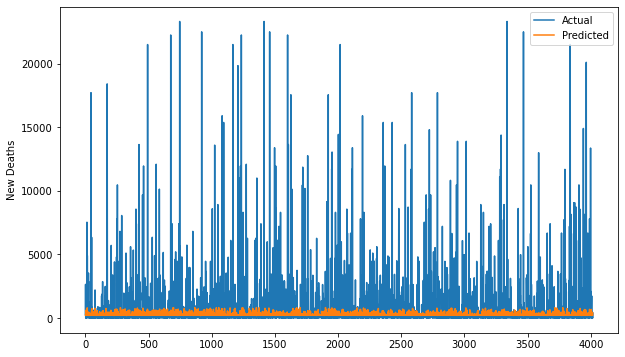

In [62]:
test_pred = model.predict(X_test)
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(test_pred, label='Predicted')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

In [63]:
mase = MeanAbsoluteScaledError(sp = 13)
mase = mase(test_pred, y_test, y_train = y_train)
mase

0.6005343518840915

In [35]:
mat = np.empty((0, 4))
metrics = pd.DataFrame(mat)
metrics = pd.DataFrame(columns=['model', 'mae', 'mase', 'rsq'])

In [36]:
df = pd.read_csv('multivar.csv')
df = df.drop(columns=['iso_code'])
df = df.drop('Unnamed: 0', axis=1)
df = df.set_index('date')
df.index = pd.to_datetime(df.index)
categorical_cols = ['continent', 'tests_units', 'season']
df = pd.get_dummies(df, columns=categorical_cols)
df = df.sort_index()

In [37]:
def get_country(data):
    data = data.drop(columns=['location'])
    return data

def process(df):
    lag1df = df.shift(1)
    lag1df.columns = ['lag1_' + str(col) for col in lag1df.columns]
    df=df[['new_deaths']].join(lag1df)
    return df.fillna(0) 

def normalize(df):
    for col in df.columns:
        if col != 'new_deaths':
            df[col]=(df[col]-df[col].mean())/df[col].std()
    return df 

## 4

In [10]:
sequence_length = 13
for country_name in df['location'].unique():
    print("Training model for", country_name)
    
    # Filter data for the current country
    country_data = df[df['location'] == country_name].copy()
    
    # Preprocess data for the current country
    country_data = get_country(country_data)
    country_data = process(country_data)
    country_data_processed = normalize(country_data)
    
    # Prepare data for LSTM
    sequences = []
    targets = []
    
    for i in range(len(country_data_processed) - sequence_length):
        sequences.append(country_data_processed['new_deaths'].values[i:i+sequence_length])
        targets.append(country_data_processed['new_deaths'].values[i+sequence_length])
    
    # Convert sequences and targets to numpy arrays
    sequences = np.array(sequences)
    targets = np.array(targets)
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(sequences, targets, test_size=0.2, random_state=42)
    
    # Define the LSTM model
    inputs = keras.layers.Input(shape=(13,1))
    lstm_out = keras.layers.LSTM(32)(inputs)
    outputs = keras.layers.Dense(1)(lstm_out)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss="mae")
    
    # Train the model
    history = model.fit(X_train.reshape((-1, sequence_length, 1)), y_train, epochs=100, batch_size=32, validation_split=0.1)
    
    # Evaluate the model
    loss = model.evaluate(X_test.reshape((-1, sequence_length, 1)), y_test)
    print("Test Loss:", loss)

Training model for Belgium


2024-03-08 12:55:56.795881: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
5/5 [==============================] - 4s 226ms/step - loss: 143.4749 - val_loss: 77.6365
Epoch 2/100
5/5 [==============================] - 0s 22ms/step - loss: 142.1108 - val_loss: 76.2666
Epoch 3/100
5/5 [==============================] - 0s 33ms/step - loss: 140.7703 - val_loss: 74.9132
Epoch 4/100
5/5 [==============================] - 0s 37ms/step - loss: 139.4431 - val_loss: 73.3955
Epoch 5/100
5/5 [==============================] - 0s 39ms/step - loss: 138.0509 - val_loss: 72.2518
Epoch 6/100
5/5 [==============================] - 0s 30ms/step - loss: 137.0330 - val_loss: 71.2988
Epoch 7/100
5/5 [==============================] - 0s 24ms/step - loss: 136.1980 - val_loss: 70.3280
Epoch 8/100
5/5 [==============================] - 0s 19ms/step - loss: 135.2699 - val_loss: 69.3847
Epoch 9/100
5/5 [==============================] - 0s 19ms/step - loss: 134.4263 - val_loss: 68.4615
Epoch 10/100
5/5 [==============================] - 0s 18ms/step - loss: 133.5661 - val_lo

5/5 [==============================] - 0s 24ms/step


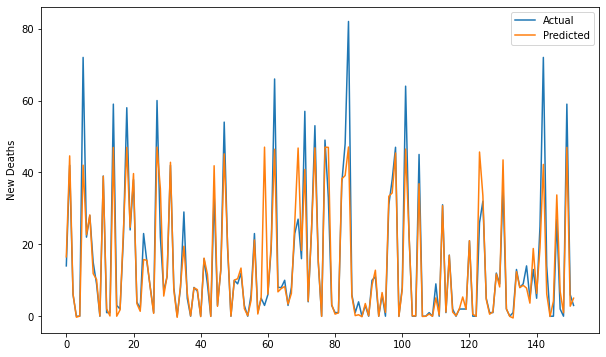

In [19]:
train_pred = model.predict(X_train.reshape((-1, sequence_length, 1)))
plt.figure(figsize=(10, 6))
plt.plot(y_train, label='Actual')
plt.plot(train_pred, label='Predicted')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

2/2 [==============================] - 0s 13ms/step


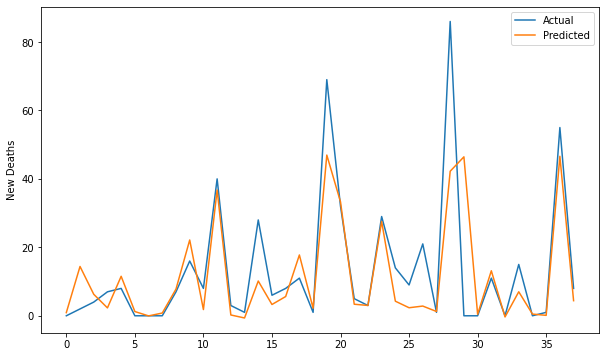

In [24]:
test_pred = model.predict(X_test.reshape((-1, sequence_length, 1)))
num_sequences = len(X_test)
flat_test_pred = np.concatenate(test_pred)

plt.figure(figsize=(10, 6))
plt.plot(np.arange(num_sequences), y_test, label='Actual')
plt.plot(np.arange(num_sequences), flat_test_pred, label='Predicted')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

In [29]:
mae = mean_absolute_error(flat_test_pred, y_test)
mase = MeanAbsoluteScaledError(sp = 13)
mase = mase(flat_test_pred, y_test, y_train = y_train)
r2 = r2_score(flat_test_pred, y_test)
new_row = {'model': '1', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

0.40780628538290775

## 5

In [40]:
sequence_length = 13
for country_name in df['location'].unique():
    print("Training model for", country_name)
    
    # Filter data for the current country
    country_data = df[df['location'] == country_name].copy()
    
    # Preprocess data for the current country
    country_data = get_country(country_data)
    country_data = process(country_data)
    country_data_processed = normalize(country_data)
    
    # Prepare data for LSTM
    sequences = []
    targets = []
    
    for i in range(len(country_data_processed) - sequence_length):
        sequences.append(country_data_processed['new_deaths'].values[i:i+sequence_length])
        targets.append(country_data_processed['new_deaths'].values[i+sequence_length])
    
    # Convert sequences and targets to numpy arrays
    sequences = np.array(sequences)
    targets = np.array(targets)
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(sequences, targets, test_size=0.2, random_state=42)
    
    # Define the LSTM model
    inputs = keras.layers.Input(shape=(13,1))
    lstm_out = keras.layers.LSTM(32)(inputs)
    outputs = keras.layers.Dense(1)(lstm_out)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mae")
    
    # Train the model
    history = model.fit(X_train.reshape((-1, sequence_length, 1)), y_train, epochs=100, batch_size=16, validation_split=0.1)
    
    # Evaluate the model
    loss = model.evaluate(X_test.reshape((-1, sequence_length, 1)), y_test)
    print("Test Loss:", loss)

Training model for Belgium
Epoch 1/100
9/9 [==============================] - 5s 110ms/step - loss: 144.1285 - val_loss: 79.2252
Epoch 2/100
9/9 [==============================] - 0s 23ms/step - loss: 143.9020 - val_loss: 78.9686
Epoch 3/100
9/9 [==============================] - 0s 18ms/step - loss: 143.6449 - val_loss: 78.6986
Epoch 4/100
9/9 [==============================] - 0s 20ms/step - loss: 143.3893 - val_loss: 78.4035
Epoch 5/100
9/9 [==============================] - 0s 21ms/step - loss: 143.0905 - val_loss: 78.0414
Epoch 6/100
9/9 [==============================] - 0s 21ms/step - loss: 142.7400 - val_loss: 77.7270
Epoch 7/100
9/9 [==============================] - 0s 21ms/step - loss: 142.4170 - val_loss: 77.3022
Epoch 8/100
9/9 [==============================] - 0s 31ms/step - loss: 141.9807 - val_loss: 76.8141
Epoch 9/100
9/9 [==============================] - 0s 35ms/step - loss: 141.5054 - val_loss: 76.4094
Epoch 10/100
9/9 [==============================] - 0s 35ms/ste

KeyboardInterrupt: 

5/5 [==============================] - 1s 3ms/step


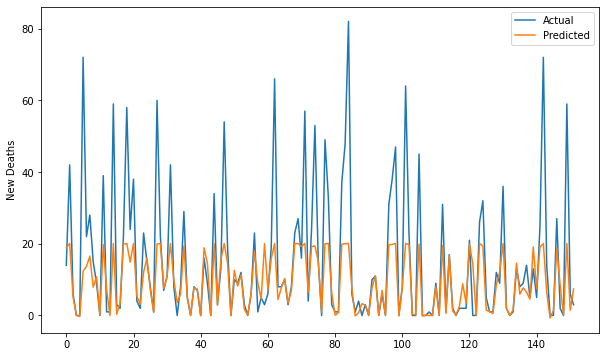

In [31]:
train_pred = model.predict(X_train.reshape((-1, sequence_length, 1)))
plt.figure(figsize=(10, 6))
plt.plot(y_train, label='Actual')
plt.plot(train_pred, label='Predicted')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

2/2 [==============================] - 0s 4ms/step


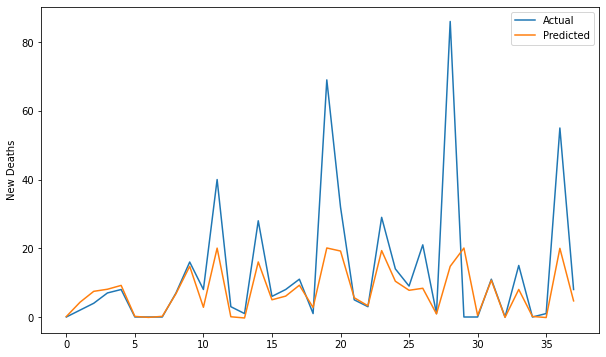

In [32]:
test_pred = model.predict(X_test.reshape((-1, sequence_length, 1)))
num_sequences = len(X_test)
flat_test_pred = np.concatenate(test_pred)

plt.figure(figsize=(10, 6))
plt.plot(np.arange(num_sequences), y_test, label='Actual')
plt.plot(np.arange(num_sequences), flat_test_pred, label='Predicted')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

In [33]:
mase = MeanAbsoluteScaledError(sp = 13)
mase = mase(flat_test_pred, y_test, y_train = y_train)
mase

0.46124660779927074

## 3

In [41]:
sequence_length = 13
for country_name in df['location'].unique():
    print("Training model for", country_name)
    
    # Filter data for the current country
    country_data = df[df['location'] == country_name].copy()
    
    # Preprocess data for the current country
    country_data = get_country(country_data)
    country_data = process(country_data)
    country_data_processed = normalize(country_data)
    
    # Prepare data for LSTM
    sequences = []
    targets = []
    
    for i in range(len(country_data_processed) - sequence_length):
        sequences.append(country_data_processed['new_deaths'].values[i:i+sequence_length])
        targets.append(country_data_processed['new_deaths'].values[i+sequence_length])
    
    # Convert sequences and targets to numpy arrays
    sequences = np.array(sequences)
    targets = np.array(targets)
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(sequences, targets, test_size=0.2, random_state=42)
    
    # Define the LSTM model
    inputs = keras.layers.Input(shape=(13,1))
    lstm1_out = keras.layers.LSTM(64, return_sequences=True)(inputs)
    lstm2_out = keras.layers.LSTM(32)(lstm1_out)
    outputs = keras.layers.Dense(1)(lstm2_out)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mae")
    
    # Train the model
    history = model.fit(X_train.reshape((-1, sequence_length, 1)), y_train, epochs=100, batch_size=16, validation_split=0.1)
    
    # Evaluate the model
    loss = model.evaluate(X_test.reshape((-1, sequence_length, 1)), y_test)
    print("Test Loss:", loss)

Training model for Belgium
Epoch 1/100
9/9 [==============================] - 9s 229ms/step - loss: 143.7717 - val_loss: 78.2455
Epoch 2/100
9/9 [==============================] - 0s 34ms/step - loss: 142.6095 - val_loss: 76.9408
Epoch 3/100
9/9 [==============================] - 0s 35ms/step - loss: 141.3592 - val_loss: 75.7261
Epoch 4/100
9/9 [==============================] - 0s 46ms/step - loss: 140.3053 - val_loss: 74.7080
Epoch 5/100
9/9 [==============================] - 0s 44ms/step - loss: 139.3910 - val_loss: 73.8586
Epoch 6/100
9/9 [==============================] - 0s 34ms/step - loss: 138.6106 - val_loss: 73.1493
Epoch 7/100
9/9 [==============================] - 0s 47ms/step - loss: 137.9505 - val_loss: 72.5416
Epoch 8/100
9/9 [==============================] - 0s 33ms/step - loss: 137.3974 - val_loss: 72.0245
Epoch 9/100
9/9 [==============================] - 0s 32ms/step - loss: 136.9476 - val_loss: 71.6407
Epoch 10/100
9/9 [==============================] - 0s 33ms/ste

5/5 [==============================] - 3s 12ms/step


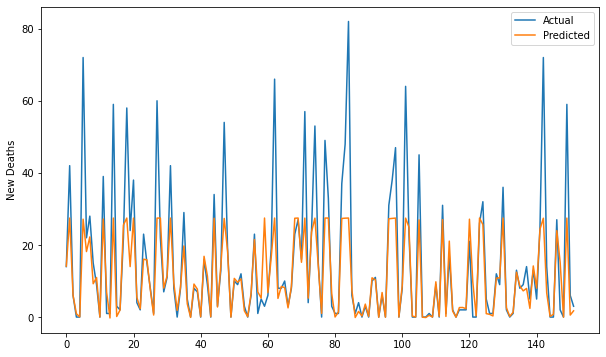

In [42]:
train_pred = model.predict(X_train.reshape((-1, sequence_length, 1)))
plt.figure(figsize=(10, 6))
plt.plot(y_train, label='Actual')
plt.plot(train_pred, label='Predicted')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

2/2 [==============================] - 0s 9ms/step


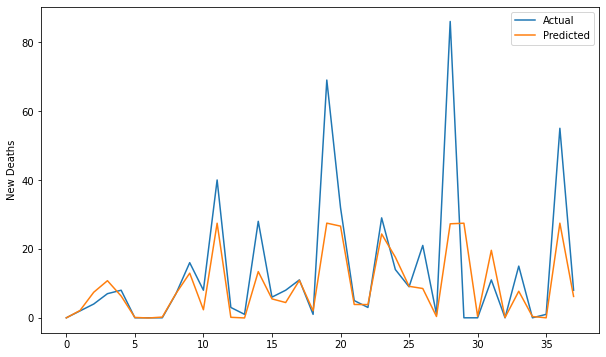

In [43]:
test_pred = model.predict(X_test.reshape((-1, sequence_length, 1)))
num_sequences = len(X_test)
flat_test_pred = np.concatenate(test_pred)

plt.figure(figsize=(10, 6))
plt.plot(np.arange(num_sequences), y_test, label='Actual')
plt.plot(np.arange(num_sequences), flat_test_pred, label='Predicted')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

In [44]:
mase = MeanAbsoluteScaledError(sp = 13)
mase = mase(flat_test_pred, y_test, y_train = y_train)
mase

0.4155421113440721

## 5

In [45]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [47]:
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)

In [48]:
sequence_length = 13
for country_name in df['location'].unique():
    print("Training model for", country_name)
    
    # Filter data for the current country
    country_data = df[df['location'] == country_name].copy()
    
    # Preprocess data for the current country
    country_data = get_country(country_data)
    country_data = process(country_data)
    country_data_processed = normalize(country_data)
    
    # Prepare data for LSTM
    sequences = []
    targets = []
    
    for i in range(len(country_data_processed) - sequence_length):
        sequences.append(country_data_processed['new_deaths'].values[i:i+sequence_length])
        targets.append(country_data_processed['new_deaths'].values[i+sequence_length])
    
    # Convert sequences and targets to numpy arrays
    sequences = np.array(sequences)
    targets = np.array(targets)
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(sequences, targets, test_size=0.2, random_state=42)
    
    # Define the LSTM model
    inputs = keras.layers.Input(shape=(13,1))
    lstm1_out = keras.layers.LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(inputs)
    lstm2_out = keras.layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2)(lstm1_out)
    outputs = keras.layers.Dense(1)(lstm2_out)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule), loss="mae")
    
    # Train the model
    history = model.fit(X_train.reshape((-1, sequence_length, 1)), y_train, epochs=100, batch_size=16, validation_split=0.1)
    
    # Evaluate the model
    loss = model.evaluate(X_test.reshape((-1, sequence_length, 1)), y_test)
    print("Test Loss:", loss)

Training model for Belgium
Epoch 1/100
9/9 [==============================] - 21s 430ms/step - loss: 144.2725 - val_loss: 78.7941
Epoch 2/100
9/9 [==============================] - 1s 81ms/step - loss: 143.1301 - val_loss: 77.7333
Epoch 3/100
9/9 [==============================] - 1s 72ms/step - loss: 142.1391 - val_loss: 76.6923
Epoch 4/100
9/9 [==============================] - 1s 68ms/step - loss: 141.1982 - val_loss: 75.6722
Epoch 5/100
9/9 [==============================] - 1s 72ms/step - loss: 140.2577 - val_loss: 74.6990
Epoch 6/100
9/9 [==============================] - 1s 72ms/step - loss: 139.3200 - val_loss: 73.7486
Epoch 7/100
9/9 [==============================] - 1s 97ms/step - loss: 138.4791 - val_loss: 72.9263
Epoch 8/100
9/9 [==============================] - 1s 109ms/step - loss: 137.7860 - val_loss: 72.3287
Epoch 9/100
9/9 [==============================] - 1s 99ms/step - loss: 137.2721 - val_loss: 71.8591
Epoch 10/100
9/9 [==============================] - 1s 104ms/

5/5 [==============================] - 2s 12ms/step


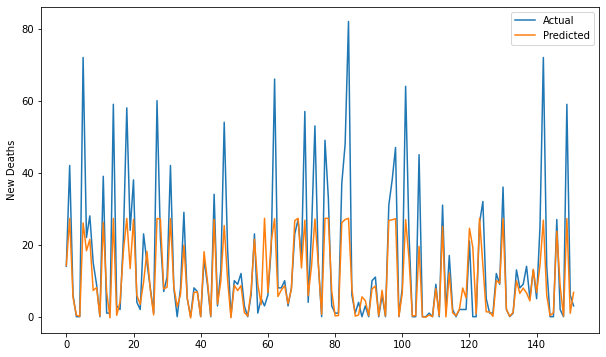

In [49]:
train_pred = model.predict(X_train.reshape((-1, sequence_length, 1)))
plt.figure(figsize=(10, 6))
plt.plot(y_train, label='Actual')
plt.plot(train_pred, label='Predicted')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

2/2 [==============================] - 0s 6ms/step


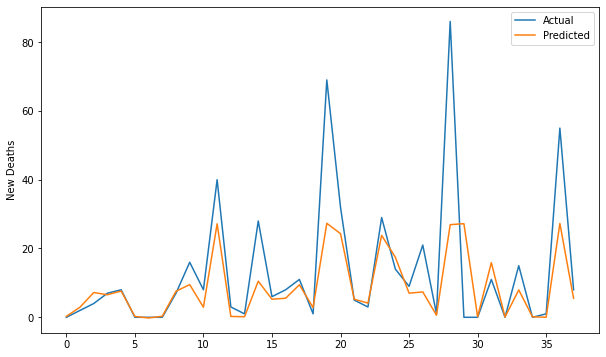

In [50]:
test_pred = model.predict(X_test.reshape((-1, sequence_length, 1)))
num_sequences = len(X_test)
flat_test_pred = np.concatenate(test_pred)

plt.figure(figsize=(10, 6))
plt.plot(np.arange(num_sequences), y_test, label='Actual')
plt.plot(np.arange(num_sequences), flat_test_pred, label='Predicted')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

In [51]:
mase = MeanAbsoluteScaledError(sp = 13)
mase = mase(flat_test_pred, y_test, y_train = y_train)
mase

0.42465217030704505

In [52]:
len(test_pred)

38

In [53]:
len(df)

2023

## 6

In [72]:
sequence_length = 13
all_sequences = []
all_targets = []

for country_name in df['location'].unique():
    print("Processing data for", country_name)
    country_data = df[df['location'] == country_name].copy()
    
    country_data = get_country(country_data)
    #country_data = process(country_data)
    country_data_processed = normalize(country_data)
    
    sequences = []
    targets = []
    
    for i in range(len(country_data_processed) - sequence_length):
        sequences.append(country_data_processed['new_deaths'].values[i:i+sequence_length])
        targets.append(country_data_processed['new_deaths'].values[i+sequence_length])
    
    all_sequences.extend(sequences)
    all_targets.extend(targets)

all_sequences = np.array(all_sequences)
all_targets = np.array(all_targets)

X_train, X_test, y_train, y_test = train_test_split(all_sequences, all_targets, test_size=0.2, random_state=42)

inputs = keras.layers.Input(shape=(sequence_length, 1))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mae")

history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.1)

loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

Processing data for Belgium
Processing data for France
Processing data for Ireland
Processing data for Czechia
Processing data for Israel
Processing data for Italy
Processing data for Chile
Processing data for Malaysia
Processing data for United States
Processing data for Estonia
Epoch 1/100
86/86 [==============================] - 7s 25ms/step - loss: 801.3077 - val_loss: 716.6359
Epoch 2/100
86/86 [==============================] - 1s 13ms/step - loss: 797.0377 - val_loss: 712.0209
Epoch 3/100
86/86 [==============================] - 1s 12ms/step - loss: 793.1013 - val_loss: 709.2285
Epoch 4/100
86/86 [==============================] - 1s 14ms/step - loss: 791.0213 - val_loss: 707.3669
Epoch 5/100
86/86 [==============================] - 1s 14ms/step - loss: 789.2740 - val_loss: 705.5352
Epoch 6/100
86/86 [==============================] - 1s 13ms/step - loss: 787.6281 - val_loss: 703.8986
Epoch 7/100
86/86 [==============================] - 1s 16ms/step - loss: 786.0919 - val_loss: 

In [73]:
train_predictions = model.predict(X_train)

48/48 [==============================] - 2s 7ms/step


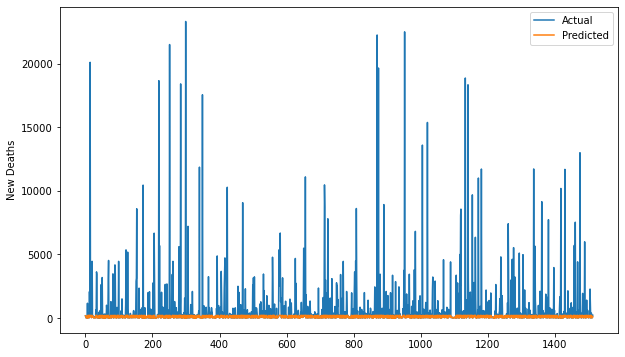

In [76]:
#train_pred = model.predict(X_train.reshape((-1, sequence_length, 1)))
plt.figure(figsize=(10, 6))
plt.plot(y_train, label='Actual')
plt.plot(train_predictions, label='Predicted')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

## 7

In [3]:
df = pd.read_csv('multivar.csv')
df = df.drop(columns=['iso_code'])
df = df.drop('Unnamed: 0', axis=1)
df = df.set_index('date')
df.index = pd.to_datetime(df.index)
categorical_cols = ['continent', 'tests_units', 'season']
df = pd.get_dummies(df, columns=categorical_cols)
df = df.sort_index()

In [4]:
def process(df):
    lag1df = df.shift(1)
    lag1df.columns = ['lag1_' + str(col) for col in lag1df.columns]
    df=df[['new_deaths']].join(lag1df)
    return df.fillna(0) 

def normalize(df):
    for col in df.columns:
        if col != 'new_deaths':
            df[col]=(df[col]-df[col].mean())/df[col].std()
    return df 

In [87]:
sequence_length = 13
all_train_preds = []
all_test_preds = []
all_y_train = []
all_y_test = []

for country_name in df['location'].unique():
    print("Training model for", country_name)
    
    # Filter by country
    country_data = df[df['location'] == country_name].copy()
    country_data = country_data.drop('location', axis=1) 
    
    # Preprocessing
    country_data_processed = process(country_data)
    country_data_processed = normalize(country_data)
    
    # Data Prep
    sequences = []
    targets = []
    
    for i in range(len(country_data_processed) - sequence_length):
        sequences.append(country_data_processed['new_deaths'].values[i:i+sequence_length])
        targets.append(country_data_processed['new_deaths'].values[i+sequence_length])
    
    sequences = np.array(sequences)
    targets = np.array(targets)
    
    # Training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(sequences, targets, test_size=0.2, random_state=42)
    
    # LSTM model
    inputs = keras.layers.Input(shape=(13,1))
    lstm_out = keras.layers.LSTM(32)(inputs)
    outputs = keras.layers.Dense(1)(lstm_out)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss="mae")
    
    # Training
    history = model.fit(X_train.reshape((-1, sequence_length, 1)), y_train, epochs=100, batch_size=32, validation_split=0.1)

    # Training results
    train_pred = model.predict(X_train.reshape((-1, sequence_length, 1)))
    # Test Predictions
    test_pred = model.predict(X_test.reshape((-1, sequence_length, 1)))

    # Append to all predictions
    all_train_preds.append(train_pred)
    all_test_preds.append(test_pred)
    all_y_train.append(y_train)
    all_y_test.append(y_test)

all_train_preds = np.concatenate(all_train_preds)
all_test_preds = np.concatenate(all_test_preds)
all_y_train = np.concatenate(all_y_train)
all_y_test = np.concatenate(all_y_test)

Training model for Belgium
Epoch 1/100
5/5 [==============================] - 4s 156ms/step - loss: 144.2005 - val_loss: 78.9092
Epoch 2/100
5/5 [==============================] - 0s 17ms/step - loss: 143.4202 - val_loss: 77.9782
Epoch 3/100
5/5 [==============================] - 0s 15ms/step - loss: 142.2519 - val_loss: 75.7933
Epoch 4/100
5/5 [==============================] - 0s 15ms/step - loss: 140.1992 - val_loss: 73.9728
Epoch 5/100
5/5 [==============================] - 0s 15ms/step - loss: 138.6463 - val_loss: 72.7651
Epoch 6/100
5/5 [==============================] - 0s 17ms/step - loss: 137.5276 - val_loss: 71.7519
Epoch 7/100
5/5 [==============================] - 0s 19ms/step - loss: 136.5527 - val_loss: 70.6945
Epoch 8/100
5/5 [==============================] - 0s 15ms/step - loss: 135.6008 - val_loss: 69.6211
Epoch 9/100
5/5 [==============================] - 0s 20ms/step - loss: 134.6406 - val_loss: 68.5907
Epoch 10/100
5/5 [==============================] - 0s 23ms/ste

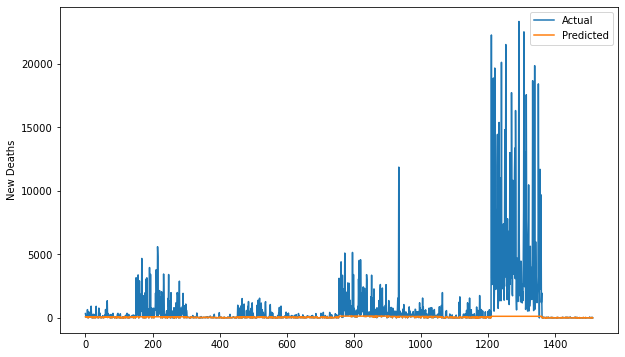

In [88]:
plt.figure(figsize=(10, 6))
plt.plot(all_y_train, label='Actual')
plt.plot(all_train_preds, label='Predicted')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

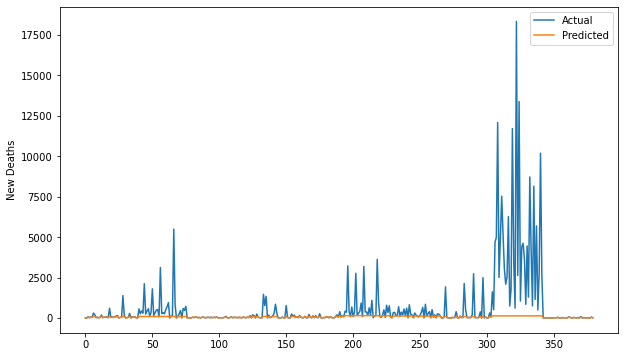

In [89]:
plt.figure(figsize=(10, 6))
plt.plot(all_y_test, label='Actual')
plt.plot(all_test_preds, label='Predicted')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

In [90]:
mase = MeanAbsoluteScaledError(sp = 13)
mase = mase(all_test_preds, all_y_test, y_train = all_y_train)
mase

0.6567295737417941

In [10]:
# Filter by country
sequence_length = 13
country_data = df[df['location'] == 'Estonia'].copy()
country_data = country_data.drop('location', axis=1) 
    
    # Preprocessing
country_data_processed = process(country_data)
country_data_processed = normalize(country_data)
    
    # Data Prep
sequences = []
targets = []
    
for i in range(len(country_data_processed) - sequence_length):
    sequences.append(country_data_processed['new_deaths'].values[i:i+sequence_length])
    targets.append(country_data_processed['new_deaths'].values[i+sequence_length])
    
sequences = np.array(sequences)
targets = np.array(targets)
    
    # Training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sequences, targets, test_size=0.2, random_state=42)

In [11]:
inputs = keras.layers.Input(shape=(13,1))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss="mae")
    
    # Training
history = model.fit(X_train.reshape((-1, sequence_length, 1)), y_train, epochs=100, batch_size=32, validation_split=0.1)

    # Training results
train_pred = model.predict(X_train.reshape((-1, sequence_length, 1)))
    # Test Predictions
test_pred = model.predict(X_test.reshape((-1, sequence_length, 1)))

2024-03-12 15:48:31.226289: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
5/5 [==============================] - 22s 1s/step - loss: 15.5712 - val_loss: 14.9297
Epoch 2/100
5/5 [==============================] - 1s 130ms/step - loss: 14.0676 - val_loss: 13.7196
Epoch 3/100
5/5 [==============================] - 0s 105ms/step - loss: 12.9628 - val_loss: 13.0760
Epoch 4/100
5/5 [==============================] - 1s 145ms/step - loss: 12.2859 - val_loss: 12.5775
Epoch 5/100
5/5 [==============================] - 1s 165ms/step - loss: 11.7012 - val_loss: 12.2614
Epoch 6/100
5/5 [==============================] - 1s 135ms/step - loss: 11.2282 - val_loss: 11.9284
Epoch 7/100
5/5 [==============================] - 1s 144ms/step - loss: 10.8118 - val_loss: 11.6891
Epoch 8/100
5/5 [==============================] - 1s 163ms/step - loss: 10.4293 - val_loss: 11.4247
Epoch 9/100
5/5 [==============================] - 1s 190ms/step - loss: 10.0720 - val_loss: 11.0729
Epoch 10/100
5/5 [==============================] - 1s 184ms/step - loss: 9.7683 - val_loss: 

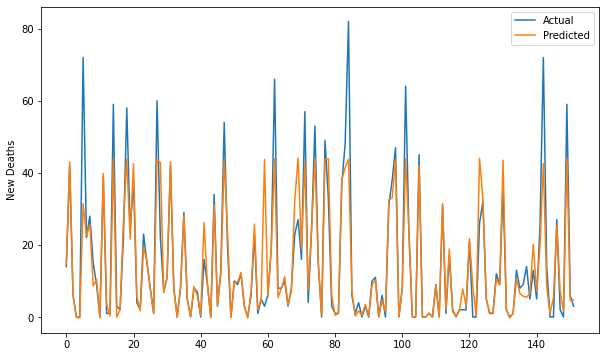

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(y_train, label='Actual')
plt.plot(train_pred, label='Predicted')
plt.ylabel('New Deaths')
plt.legend()
plt.show()

# Attempt 1

In [48]:
mat = np.empty((0, 4))
metrics = pd.DataFrame(mat)
metrics = pd.DataFrame(columns=['country', 'model', 'mae', 'mase'])

In [16]:
df = pd.read_csv('multivar.csv')
df = df.drop(columns=['iso_code'])
df = df.drop('Unnamed: 0', axis=1)
df = df.set_index('date')
df.index = pd.to_datetime(df.index)
categorical_cols = ['continent', 'tests_units', 'season', 'location']
df = pd.get_dummies(df, columns=categorical_cols)
df = df.sort_index()

In [17]:
def process(df):
    lag1df = df.shift(1)
    lag1df.columns = ['lag1_' + str(col) for col in lag1df.columns]
    df=df[['new_deaths']].join(lag1df)
    return df.fillna(0) 

def normalize(df):
    for col in df.columns:
        if col != 'new_deaths':
            df[col]=(df[col]-df[col].mean())/df[col].std()
    return df 

In [18]:
# Preprocessing
country_data_processed = process(df)
country_data_processed = normalize(country_data_processed)
    
# Data Prep
sequences = []
targets = []
sequence_length = 13
    
for i in range(len(country_data_processed) - sequence_length):
    sequences.append(country_data_processed['new_deaths'].values[i:i+sequence_length])
    targets.append(country_data_processed['new_deaths'].values[i+sequence_length])
    
sequences = np.array(sequences)
targets = np.array(targets)
    
# Training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sequences, targets, test_size=0.2, random_state=42)
    
# LSTM model
inputs = keras.layers.Input(shape=(13,1))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss="mae")
    
# Training
history = model.fit(X_train.reshape((-1, sequence_length, 1)), y_train, epochs=100, batch_size=32, validation_split=0.1)

# Training results
train_pred = model.predict(X_train.reshape((-1, sequence_length, 1)))


Epoch 1/100
455/455 [==============================] - 28s 42ms/step - loss: 804.7862 - val_loss: 897.6067
Epoch 2/100
455/455 [==============================] - 17s 37ms/step - loss: 765.9317 - val_loss: 866.4401
Epoch 3/100
455/455 [==============================] - 15s 33ms/step - loss: 738.6508 - val_loss: 838.3926
Epoch 4/100
455/455 [==============================] - 16s 36ms/step - loss: 717.2690 - val_loss: 818.1766
Epoch 5/100
455/455 [==============================] - 16s 35ms/step - loss: 697.0618 - val_loss: 797.0925
Epoch 6/100
455/455 [==============================] - 18s 39ms/step - loss: 679.7579 - val_loss: 783.1378
Epoch 7/100
455/455 [==============================] - 18s 40ms/step - loss: 668.8233 - val_loss: 779.2695
Epoch 8/100
455/455 [==============================] - 19s 41ms/step - loss: 661.7837 - val_loss: 771.6852
Epoch 9/100
455/455 [==============================] - 18s 40ms/step - loss: 653.3514 - val_loss: 756.5957
Epoch 10/100
455/455 [===============

2/2 [==============================] - 0s 14ms/step


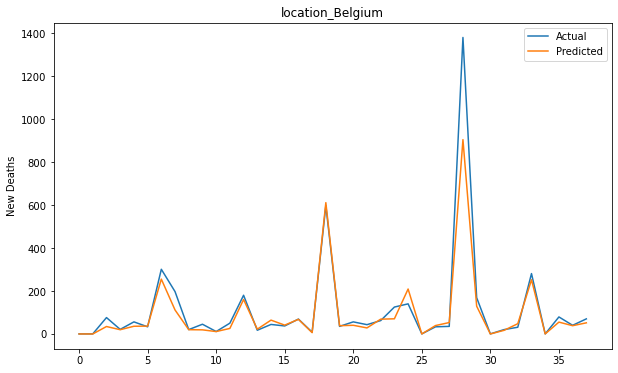

2/2 [==============================] - 0s 8ms/step


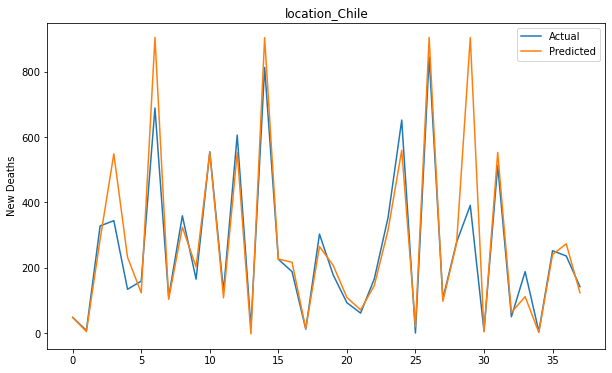

2/2 [==============================] - 0s 8ms/step


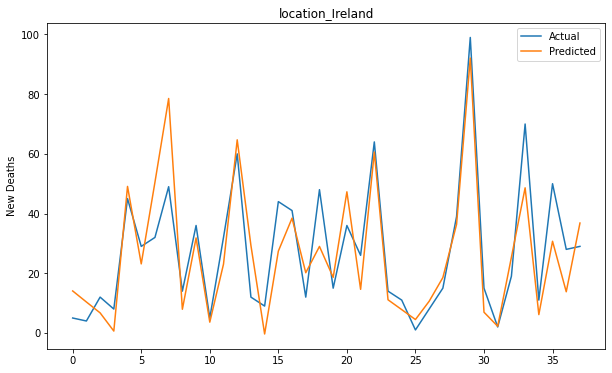

2/2 [==============================] - 0s 8ms/step


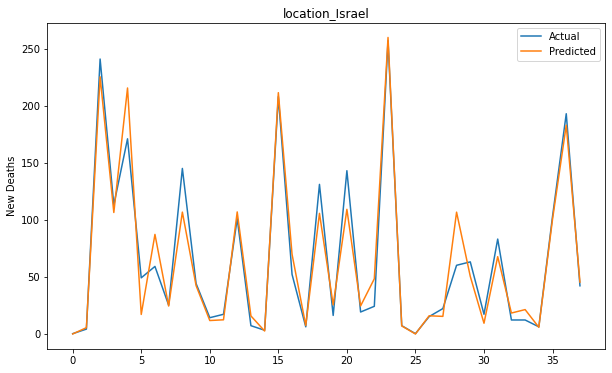

2/2 [==============================] - 0s 7ms/step


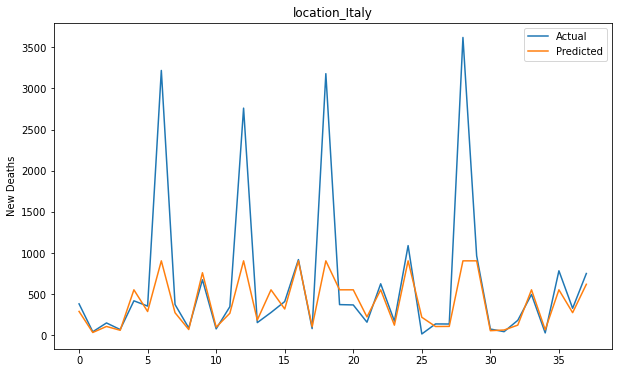

2/2 [==============================] - 0s 7ms/step


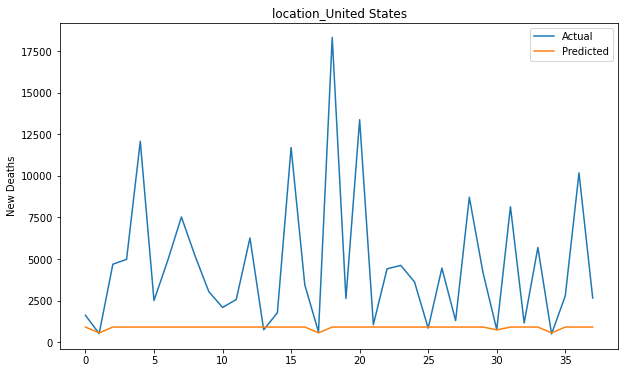

2/2 [==============================] - 0s 7ms/step


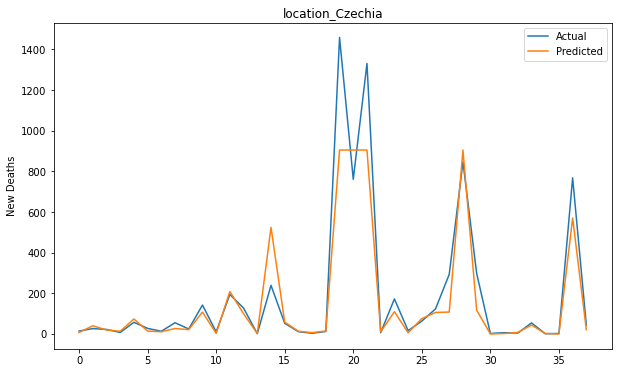

2/2 [==============================] - 0s 7ms/step


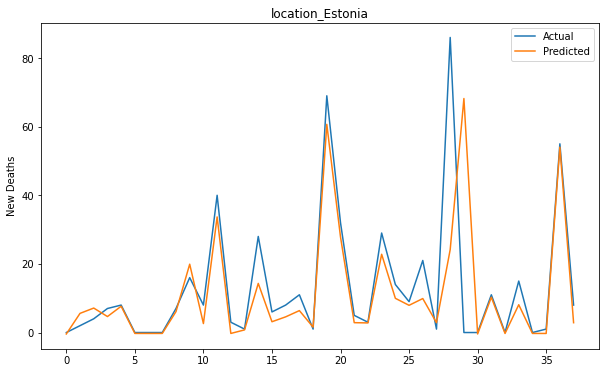

2/2 [==============================] - 0s 7ms/step


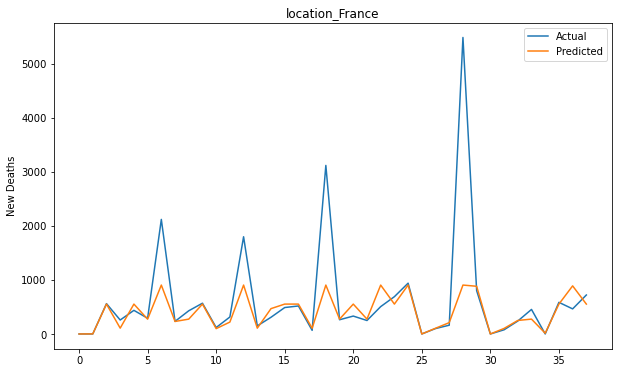

2/2 [==============================] - 0s 8ms/step


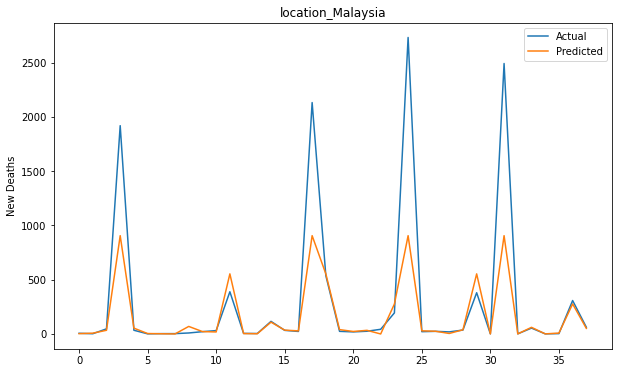

In [56]:
for country_name in ['location_Belgium', 'location_Chile', 'location_Ireland', 'location_Israel', 'location_Italy',
 'location_United States', 'location_Czechia', 'location_Estonia', 'location_France', 'location_Malaysia']:
    country_data = df[df[country_name] == 1]
    country_data = normalize(country_data)
    sequences = []
    targets = []
    sequence_length = 13

    for i in range(len(country_data) - sequence_length):
        sequences.append(country_data['new_deaths'].values[i:i+sequence_length])
        targets.append(country_data['new_deaths'].values[i+sequence_length])
    
    sequences = np.array(sequences)
    targets = np.array(targets)
    
    # Training and testing sets
    country_X_train, country_X_test, country_y_train, country_y_test = train_test_split(sequences, targets, test_size=0.2, random_state=42)

    # test predictions
    test_pred = model.predict(country_X_test.reshape((-1, sequence_length, 1)))

    plt.figure(figsize=(10, 6))
    plt.plot(country_y_test, label='Actual')
    plt.plot(test_pred, label='Predicted')
    plt.ylabel('New Deaths')
    plt.title(country_name)
    plt.legend()
    plt.show()

    mae = mean_absolute_error(test_pred, country_y_test)
    mase = MeanAbsoluteScaledError(sp = 13)
    mase = mase(test_pred, country_y_test, y_train = y_train)
    new_row = {'country': country_name, 'model': '1', 'mae': mae, 'mase': mase}
    metrics = metrics.append(new_row, ignore_index=True)

# Attempt 2

In [58]:
# Preprocessing
country_data_processed = process(df)
country_data_processed = normalize(country_data_processed)
    
# Data Prep
sequences = []
targets = []
sequence_length = 13
    
for i in range(len(country_data_processed) - sequence_length):
    sequences.append(country_data_processed['new_deaths'].values[i:i+sequence_length])
    targets.append(country_data_processed['new_deaths'].values[i+sequence_length])
    
sequences = np.array(sequences)
targets = np.array(targets)
    
# Training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sequences, targets, test_size=0.2, random_state=42)
    
# LSTM model
inputs = keras.layers.Input(shape=(13,1))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mae")
    
# Training
history = model.fit(X_train.reshape((-1, sequence_length, 1)), y_train, epochs=50, batch_size=16, validation_split=0.1)

# Training results
train_pred = model.predict(X_train.reshape((-1, sequence_length, 1)))

Epoch 1/50
909/909 [==============================] - 61s 45ms/step - loss: 828.0400 - val_loss: 937.4618
Epoch 2/50
909/909 [==============================] - 38s 42ms/step - loss: 813.6384 - val_loss: 925.0582
Epoch 3/50
909/909 [==============================] - 39s 43ms/step - loss: 803.1003 - val_loss: 915.2969
Epoch 4/50
909/909 [==============================] - 37s 41ms/step - loss: 794.3342 - val_loss: 906.5728
Epoch 5/50
909/909 [==============================] - 39s 43ms/step - loss: 786.3140 - val_loss: 898.3291
Epoch 6/50
909/909 [==============================] - 40s 43ms/step - loss: 778.7834 - val_loss: 890.6275
Epoch 7/50
909/909 [==============================] - 39s 43ms/step - loss: 771.5212 - val_loss: 882.9149
Epoch 8/50
909/909 [==============================] - 40s 44ms/step - loss: 764.6540 - val_loss: 875.9001
Epoch 9/50
909/909 [==============================] - 37s 41ms/step - loss: 758.1254 - val_loss: 868.9884
Epoch 10/50
909/909 [=========================

2/2 [==============================] - 0s 20ms/step


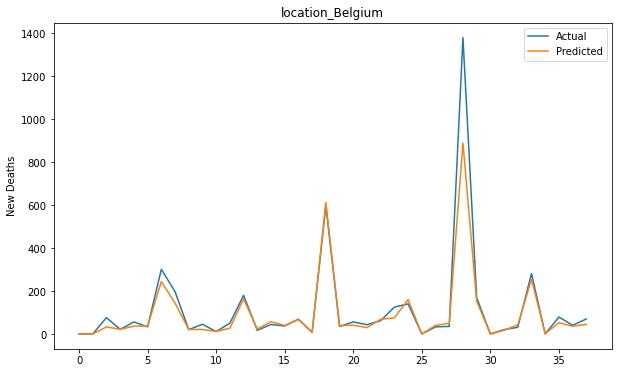

2/2 [==============================] - 0s 29ms/step


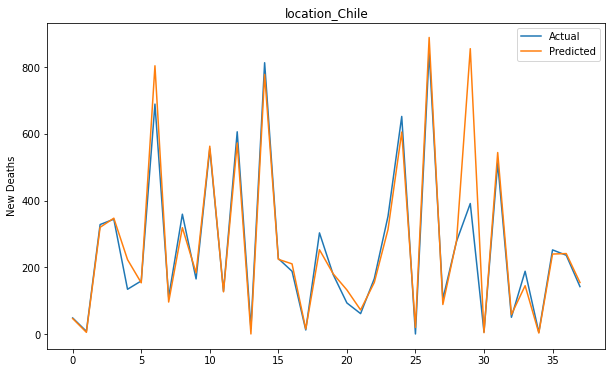

2/2 [==============================] - 0s 17ms/step


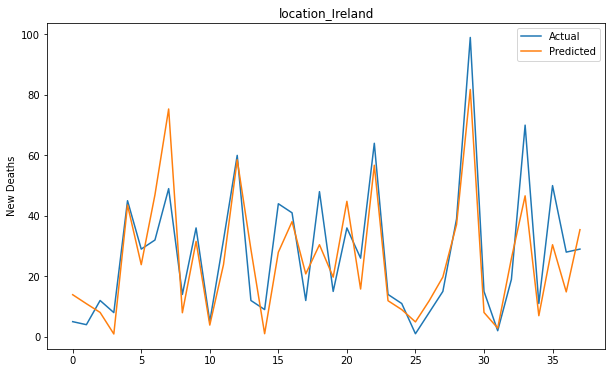

2/2 [==============================] - 0s 14ms/step


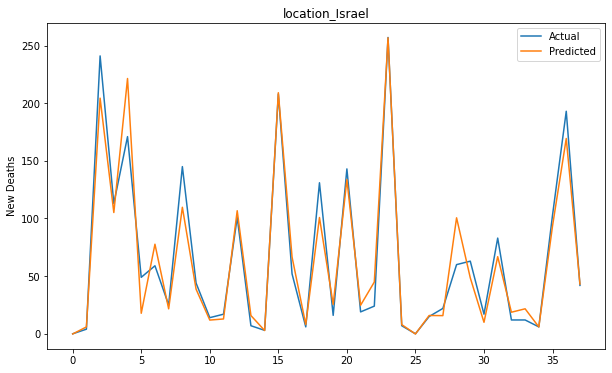

2/2 [==============================] - 0s 14ms/step


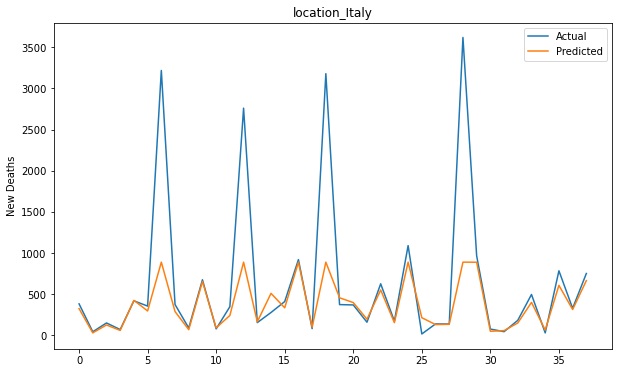

2/2 [==============================] - 0s 14ms/step


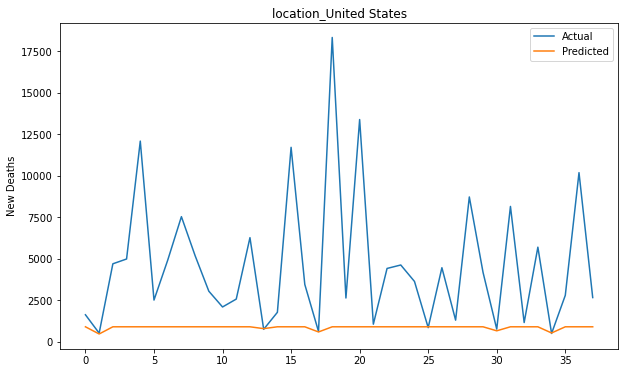

2/2 [==============================] - 0s 16ms/step


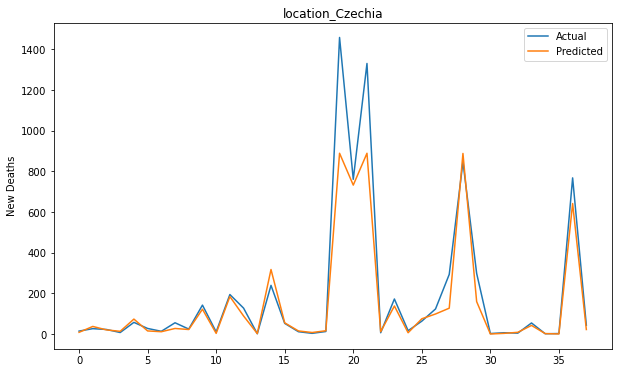

2/2 [==============================] - 0s 17ms/step


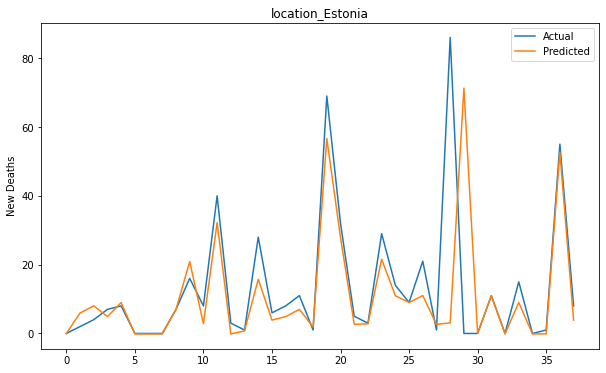

2/2 [==============================] - 1s 25ms/step


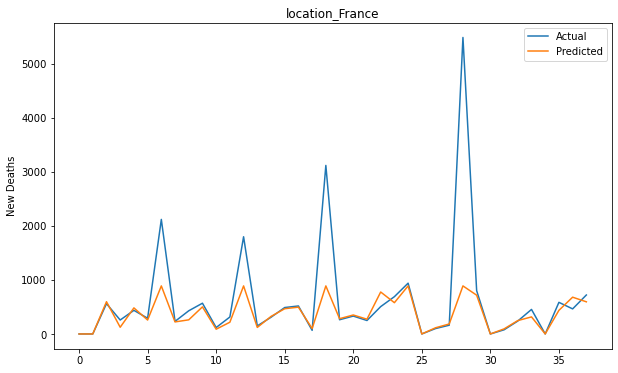

2/2 [==============================] - 0s 18ms/step


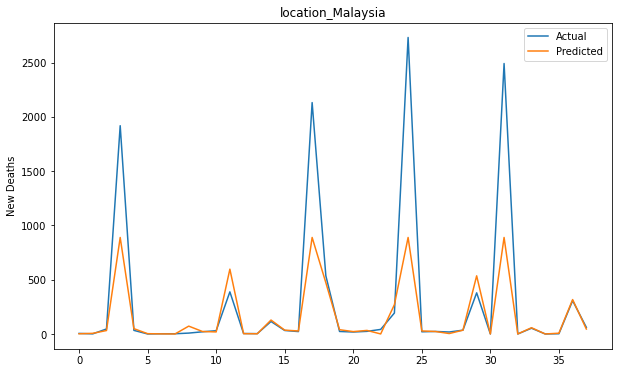

In [60]:
for country_name in ['location_Belgium', 'location_Chile', 'location_Ireland', 'location_Israel', 'location_Italy',
 'location_United States', 'location_Czechia', 'location_Estonia', 'location_France', 'location_Malaysia']:
    country_data = df[df[country_name] == 1]
    country_data = normalize(country_data)
    sequences = []
    targets = []
    sequence_length = 13

    for i in range(len(country_data) - sequence_length):
        sequences.append(country_data['new_deaths'].values[i:i+sequence_length])
        targets.append(country_data['new_deaths'].values[i+sequence_length])
    
    sequences = np.array(sequences)
    targets = np.array(targets)
    
    # Training and testing sets
    country_X_train, country_X_test, country_y_train, country_y_test = train_test_split(sequences, targets, test_size=0.2, random_state=42)

    # test predictions
    test_pred = model.predict(country_X_test.reshape((-1, sequence_length, 1)))

    plt.figure(figsize=(10, 6))
    plt.plot(country_y_test, label='Actual')
    plt.plot(test_pred, label='Predicted')
    plt.ylabel('New Deaths')
    plt.title(country_name)
    plt.legend()
    plt.show()

    mae = mean_absolute_error(test_pred, country_y_test)
    mase = MeanAbsoluteScaledError(sp = 13)
    mase = mase(test_pred, country_y_test, y_train = y_train)
    new_row = {'country': country_name, 'model': '2', 'mae': mae, 'mase': mase}
    metrics = metrics.append(new_row, ignore_index=True)

# Attempt 3

In [61]:
# Preprocessing
country_data_processed = process(df)
country_data_processed = normalize(country_data_processed)
    
# Data Prep
sequences = []
targets = []
sequence_length = 13
    
for i in range(len(country_data_processed) - sequence_length):
    sequences.append(country_data_processed['new_deaths'].values[i:i+sequence_length])
    targets.append(country_data_processed['new_deaths'].values[i+sequence_length])
    
sequences = np.array(sequences)
targets = np.array(targets)
    
# Training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sequences, targets, test_size=0.2, random_state=42)
    
# LSTM model
inputs = keras.layers.Input(shape=(13,1))
lstm1_out = keras.layers.LSTM(64, return_sequences=True)(inputs)
lstm2_out = keras.layers.LSTM(32)(lstm1_out)
outputs = keras.layers.Dense(1)(lstm2_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mae")
    
# Training
history = model.fit(X_train.reshape((-1, sequence_length, 1)), y_train, epochs=50, batch_size=16, validation_split=0.1)

# Training results
train_pred = model.predict(X_train.reshape((-1, sequence_length, 1)))

Epoch 1/50
909/909 [==============================] - 49s 44ms/step - loss: 823.9180 - val_loss: 931.9345
Epoch 2/50
909/909 [==============================] - 50s 55ms/step - loss: 807.6155 - val_loss: 918.0688
Epoch 3/50
909/909 [==============================] - 53s 59ms/step - loss: 795.6975 - val_loss: 906.7043
Epoch 4/50
909/909 [==============================] - 54s 59ms/step - loss: 785.3356 - val_loss: 896.1113
Epoch 5/50
909/909 [==============================] - 56s 61ms/step - loss: 775.6805 - val_loss: 886.0433
Epoch 6/50
909/909 [==============================] - 58s 64ms/step - loss: 766.5788 - val_loss: 876.7245
Epoch 7/50
909/909 [==============================] - 60s 66ms/step - loss: 758.0884 - val_loss: 867.9593
Epoch 8/50
909/909 [==============================] - 61s 67ms/step - loss: 750.1437 - val_loss: 859.7312
Epoch 9/50
909/909 [==============================] - 51s 56ms/step - loss: 742.6895 - val_loss: 851.7391
Epoch 10/50
909/909 [=========================

2/2 [==============================] - 0s 22ms/step


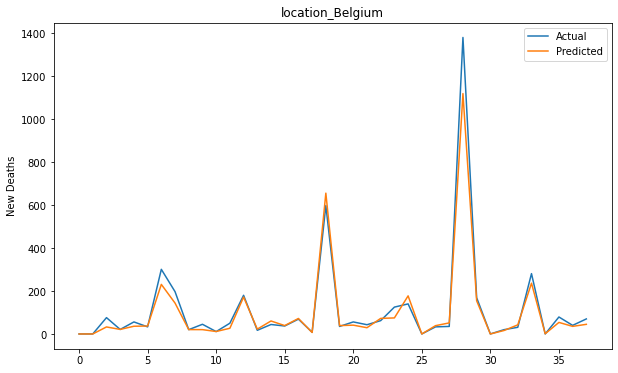

2/2 [==============================] - 0s 18ms/step


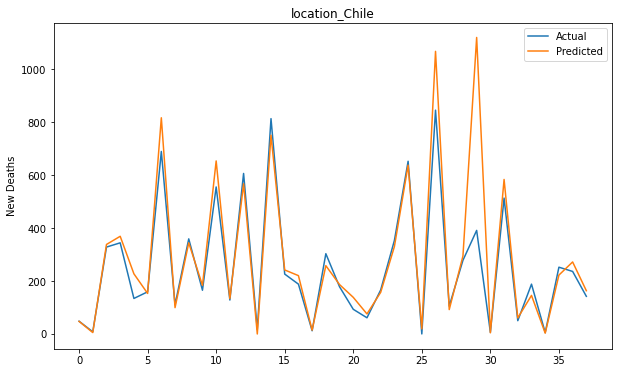

2/2 [==============================] - 0s 22ms/step


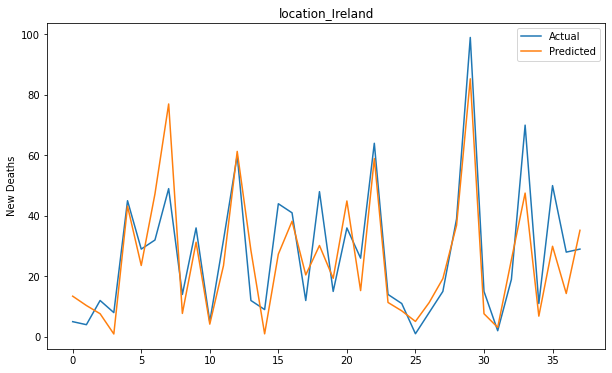

2/2 [==============================] - 0s 19ms/step


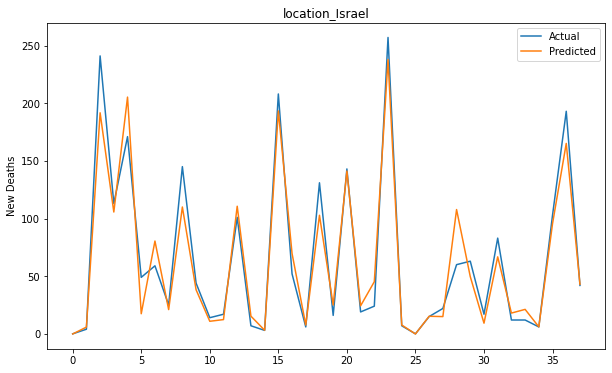

2/2 [==============================] - 0s 15ms/step


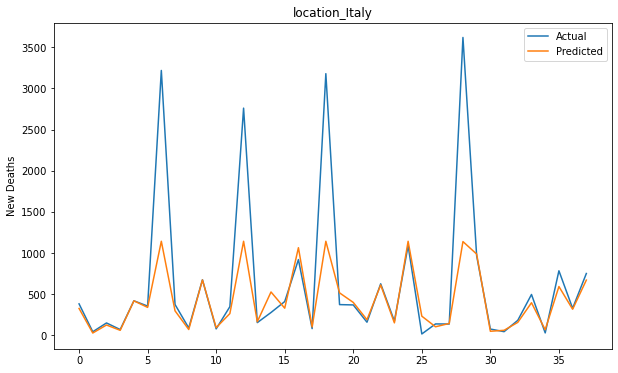

2/2 [==============================] - 0s 15ms/step


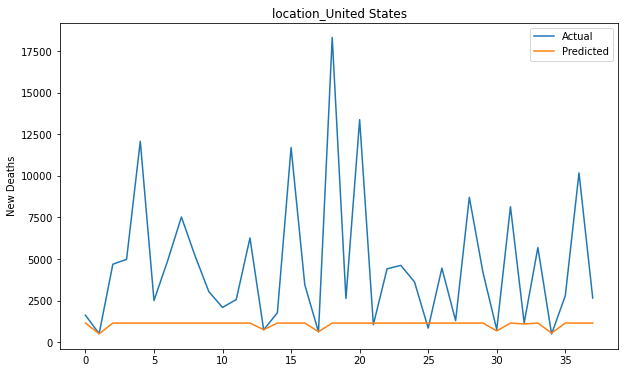

2/2 [==============================] - 0s 16ms/step


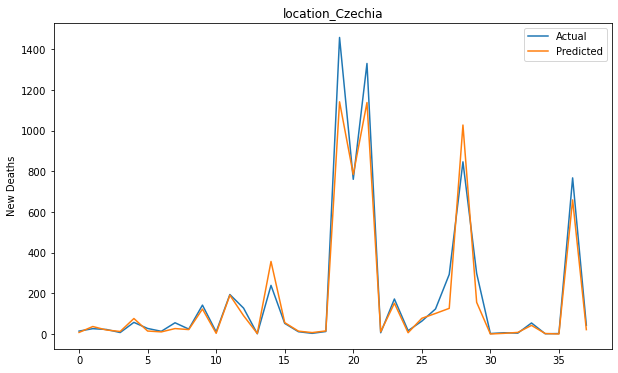

2/2 [==============================] - 0s 16ms/step


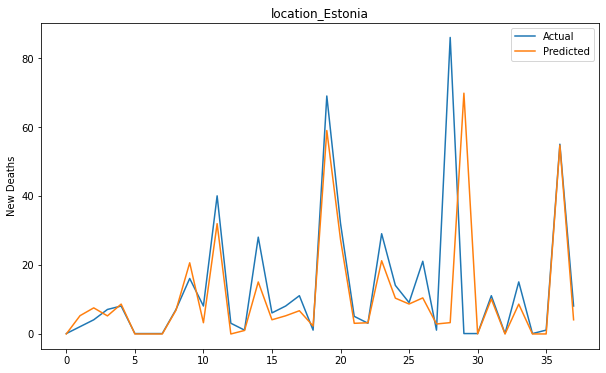

2/2 [==============================] - 0s 14ms/step


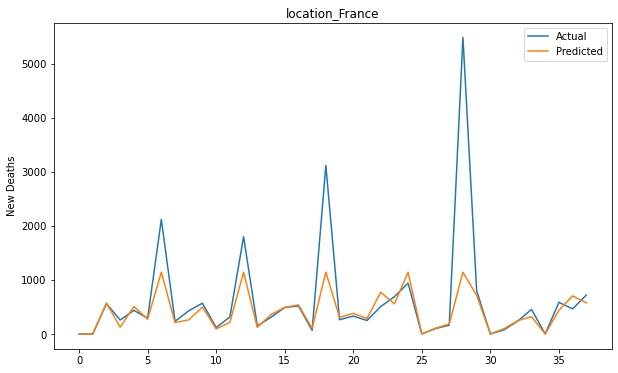

2/2 [==============================] - 0s 13ms/step


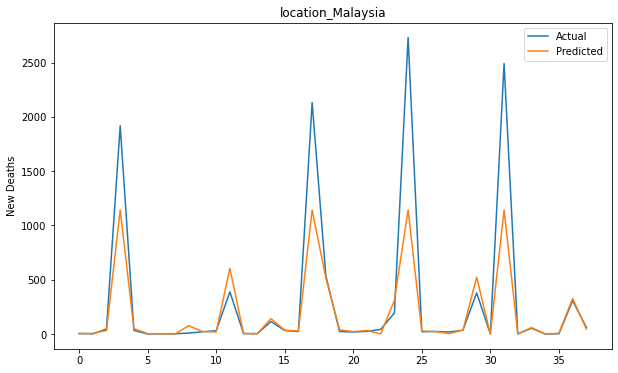

In [63]:
for country_name in ['location_Belgium', 'location_Chile', 'location_Ireland', 'location_Israel', 'location_Italy',
 'location_United States', 'location_Czechia', 'location_Estonia', 'location_France', 'location_Malaysia']:
    country_data = df[df[country_name] == 1]
    country_data = normalize(country_data)
    sequences = []
    targets = []
    sequence_length = 13

    for i in range(len(country_data) - sequence_length):
        sequences.append(country_data['new_deaths'].values[i:i+sequence_length])
        targets.append(country_data['new_deaths'].values[i+sequence_length])
    
    sequences = np.array(sequences)
    targets = np.array(targets)
    
    # Training and testing sets
    country_X_train, country_X_test, country_y_train, country_y_test = train_test_split(sequences, targets, test_size=0.2, random_state=42)

    # test predictions
    test_pred = model.predict(country_X_test.reshape((-1, sequence_length, 1)))

    plt.figure(figsize=(10, 6))
    plt.plot(country_y_test, label='Actual')
    plt.plot(test_pred, label='Predicted')
    plt.ylabel('New Deaths')
    plt.title(country_name)
    plt.legend()
    plt.show()

    mae = mean_absolute_error(test_pred, country_y_test)
    mase = MeanAbsoluteScaledError(sp = 13)
    mase = mase(test_pred, country_y_test, y_train = y_train)
    new_row = {'country': country_name, 'model': '3', 'mae': mae, 'mase': mase}
    metrics = metrics.append(new_row, ignore_index=True)

# Attempt 4

In [65]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [66]:
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)

In [67]:
# Preprocessing
country_data_processed = process(df)
country_data_processed = normalize(country_data_processed)
    
# Data Prep
sequences = []
targets = []
sequence_length = 13
    
for i in range(len(country_data_processed) - sequence_length):
    sequences.append(country_data_processed['new_deaths'].values[i:i+sequence_length])
    targets.append(country_data_processed['new_deaths'].values[i+sequence_length])
    
sequences = np.array(sequences)
targets = np.array(targets)
    
# Training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sequences, targets, test_size=0.2, random_state=42)
    
# LSTM model
inputs = keras.layers.Input(shape=(13,1))
lstm1_out = keras.layers.LSTM(64, return_sequences=True)(inputs)
lstm2_out = keras.layers.LSTM(32)(lstm1_out)
outputs = keras.layers.Dense(1)(lstm2_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule), loss="mae")
    
# Training
history = model.fit(X_train.reshape((-1, sequence_length, 1)), y_train, epochs=50, batch_size=16, validation_split=0.1)

# Training results
train_pred = model.predict(X_train.reshape((-1, sequence_length, 1)))

Epoch 1/50
909/909 [==============================] - 74s 66ms/step - loss: 824.3130 - val_loss: 932.5862
Epoch 2/50
909/909 [==============================] - 63s 69ms/step - loss: 808.1519 - val_loss: 918.6983
Epoch 3/50
909/909 [==============================] - 60s 66ms/step - loss: 796.3787 - val_loss: 907.6208
Epoch 4/50
909/909 [==============================] - 61s 67ms/step - loss: 786.2834 - val_loss: 897.4815
Epoch 5/50
909/909 [==============================] - 63s 69ms/step - loss: 776.9882 - val_loss: 887.5892
Epoch 6/50
909/909 [==============================] - 66s 72ms/step - loss: 768.2545 - val_loss: 879.1935
Epoch 7/50
909/909 [==============================] - 61s 67ms/step - loss: 760.0346 - val_loss: 870.0353
Epoch 8/50
909/909 [==============================] - 61s 67ms/step - loss: 752.4871 - val_loss: 862.3627
Epoch 9/50
909/909 [==============================] - 58s 64ms/step - loss: 745.4115 - val_loss: 855.0477
Epoch 10/50
909/909 [=========================

2/2 [==============================] - 0s 18ms/step


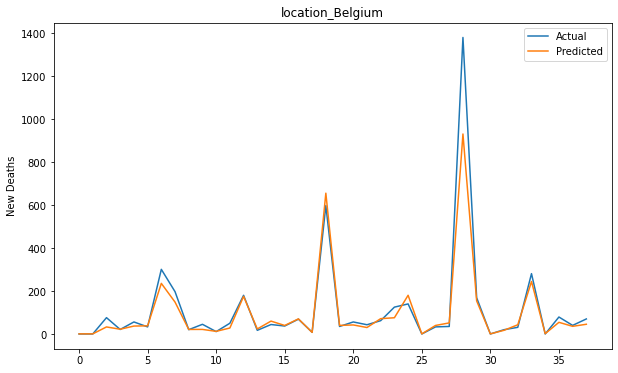

2/2 [==============================] - 0s 16ms/step


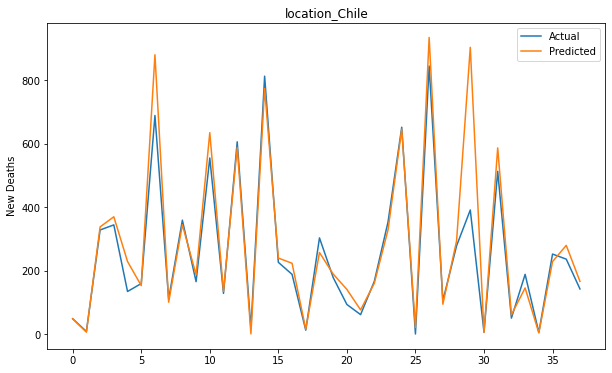

2/2 [==============================] - 0s 15ms/step


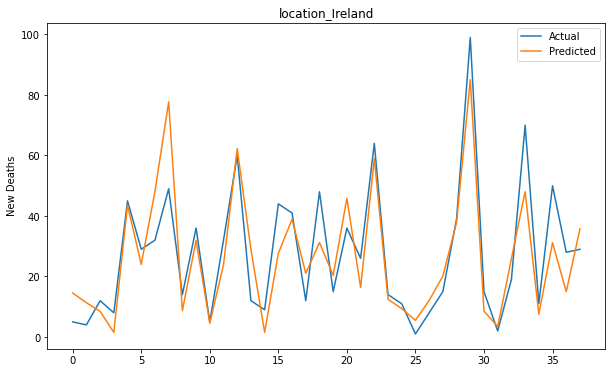

2/2 [==============================] - 0s 16ms/step


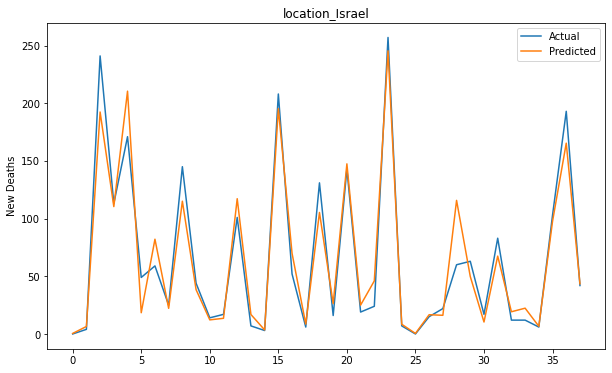

2/2 [==============================] - 0s 35ms/step


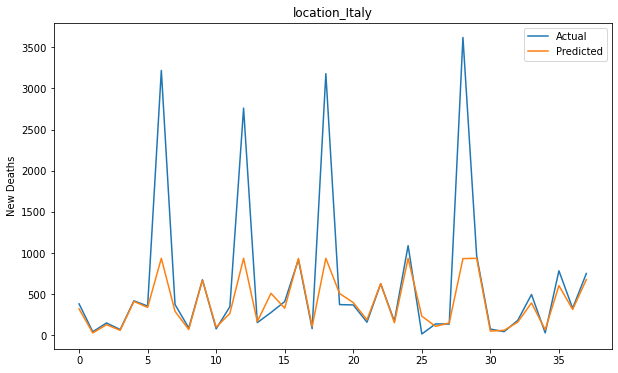

2/2 [==============================] - 0s 19ms/step


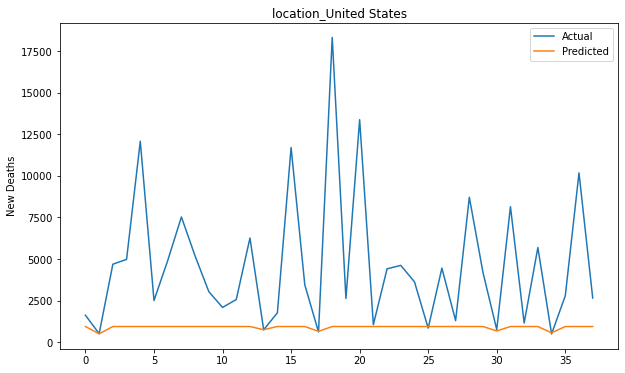

2/2 [==============================] - 0s 21ms/step


2/2 [==============================] - 0s 22ms/step


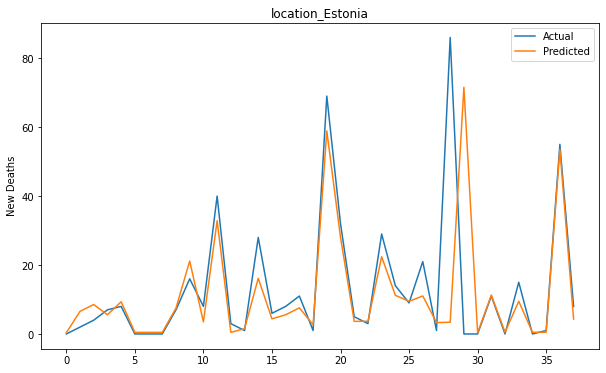

2/2 [==============================] - 0s 18ms/step


2/2 [==============================] - 0s 21ms/step


In [68]:
for country_name in ['location_Belgium', 'location_Chile', 'location_Ireland', 'location_Israel', 'location_Italy',
 'location_United States', 'location_Czechia', 'location_Estonia', 'location_France', 'location_Malaysia']:
    country_data = df[df[country_name] == 1]
    country_data = normalize(country_data)
    sequences = []
    targets = []
    sequence_length = 13

    for i in range(len(country_data) - sequence_length):
        sequences.append(country_data['new_deaths'].values[i:i+sequence_length])
        targets.append(country_data['new_deaths'].values[i+sequence_length])
    
    sequences = np.array(sequences)
    targets = np.array(targets)
    
    # Training and testing sets
    country_X_train, country_X_test, country_y_train, country_y_test = train_test_split(sequences, targets, test_size=0.2, random_state=42)

    # test predictions
    test_pred = model.predict(country_X_test.reshape((-1, sequence_length, 1)))

    plt.figure(figsize=(10, 6))
    plt.plot(country_y_test, label='Actual')
    plt.plot(test_pred, label='Predicted')
    plt.ylabel('New Deaths')
    plt.title(country_name)
    plt.legend()
    plt.show()

    mae = mean_absolute_error(test_pred, country_y_test)
    mase = MeanAbsoluteScaledError(sp = 13)
    mase = mase(test_pred, country_y_test, y_train = y_train)
    new_row = {'country': country_name, 'model': '4', 'mae': mae, 'mase': mase}
    metrics = metrics.append(new_row, ignore_index=True)

# Attempt 5

In [70]:
# Preprocessing
country_data_processed = process(df)
country_data_processed = normalize(country_data_processed)
    
# Data Prep
sequences = []
targets = []
sequence_length = 13
    
for i in range(len(country_data_processed) - sequence_length):
    sequences.append(country_data_processed['new_deaths'].values[i:i+sequence_length])
    targets.append(country_data_processed['new_deaths'].values[i+sequence_length])
    
sequences = np.array(sequences)
targets = np.array(targets)
    
# Training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sequences, targets, test_size=0.2, random_state=42)
    
# LSTM model
inputs = keras.layers.Input(shape=(13,1))
lstm1_out = keras.layers.LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(inputs)
lstm2_out = keras.layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2)(lstm1_out)
outputs = keras.layers.Dense(1)(lstm2_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule), loss="mae")
    
# Training
history = model.fit(X_train.reshape((-1, sequence_length, 1)), y_train, epochs=50, batch_size=16, validation_split=0.1)

# Training results
train_pred = model.predict(X_train.reshape((-1, sequence_length, 1)))

Epoch 1/50
909/909 [==============================] - 136s 110ms/step - loss: 824.9486 - val_loss: 933.4106
Epoch 2/50
909/909 [==============================] - 79s 87ms/step - loss: 809.0970 - val_loss: 920.5129
Epoch 3/50
909/909 [==============================] - 106s 116ms/step - loss: 797.5592 - val_loss: 910.1892
Epoch 4/50
909/909 [==============================] - 113s 125ms/step - loss: 787.5655 - val_loss: 899.5527
Epoch 5/50
909/909 [==============================] - 107s 118ms/step - loss: 778.4178 - val_loss: 890.8408
Epoch 6/50
909/909 [==============================] - 100s 110ms/step - loss: 769.8770 - val_loss: 882.8386
Epoch 7/50
909/909 [==============================] - 96s 106ms/step - loss: 761.8922 - val_loss: 875.5891
Epoch 8/50
909/909 [==============================] - 99s 109ms/step - loss: 754.6143 - val_loss: 868.4904
Epoch 9/50
909/909 [==============================] - 100s 110ms/step - loss: 747.9673 - val_loss: 862.3090
Epoch 10/50
909/909 [===========

2/2 [==============================] - 0s 36ms/step


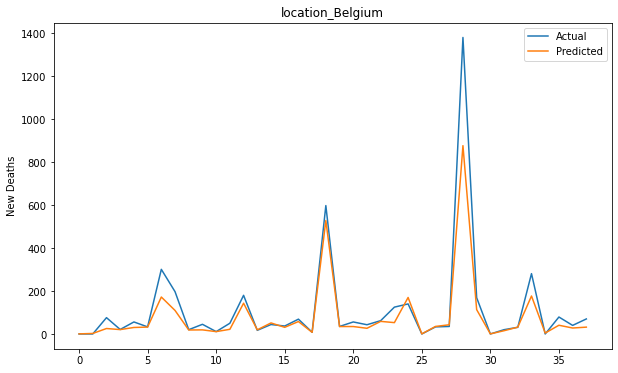

2/2 [==============================] - 0s 21ms/step


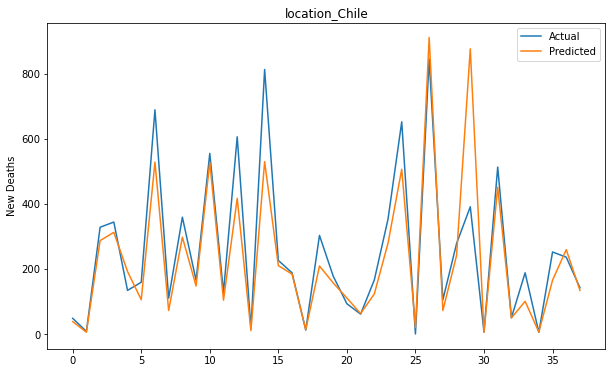

2/2 [==============================] - 0s 38ms/step


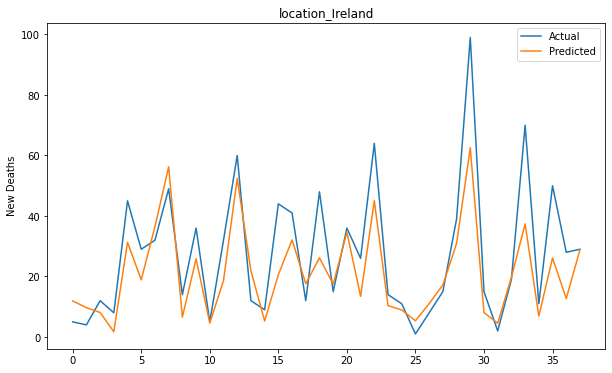

2/2 [==============================] - 0s 24ms/step


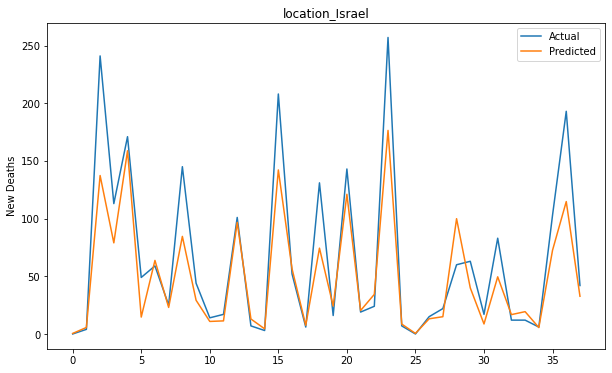

2/2 [==============================] - 0s 22ms/step


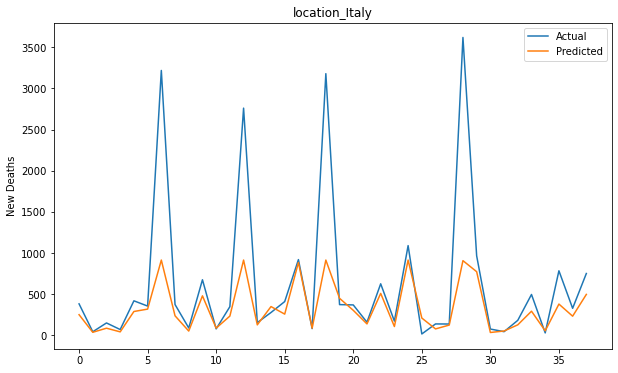

2/2 [==============================] - 0s 32ms/step


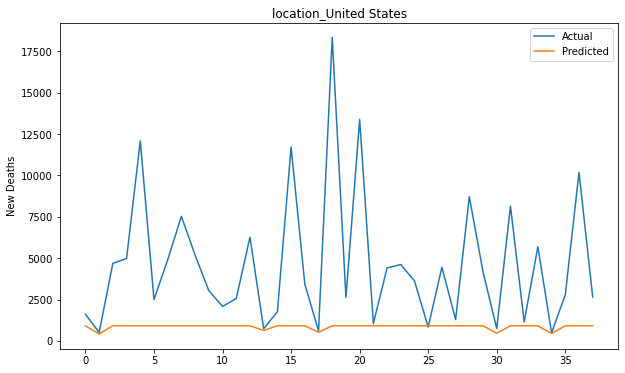

2/2 [==============================] - 0s 27ms/step


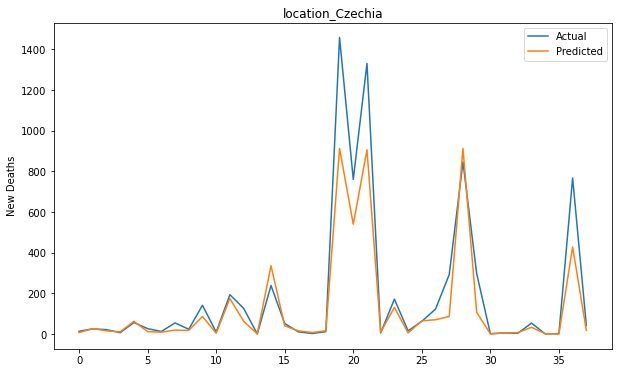

2/2 [==============================] - 0s 34ms/step


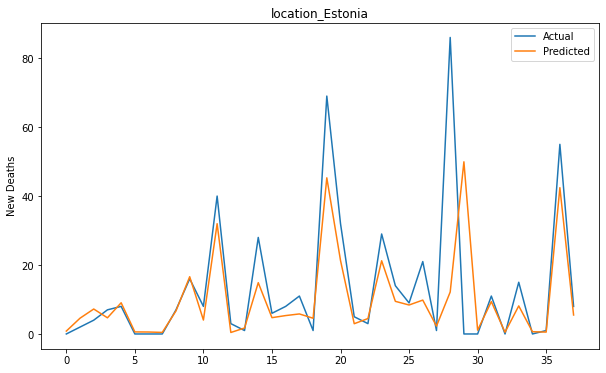

2/2 [==============================] - 0s 24ms/step


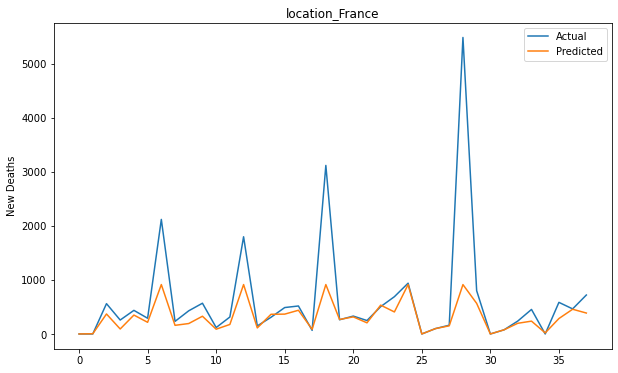

2/2 [==============================] - 0s 31ms/step


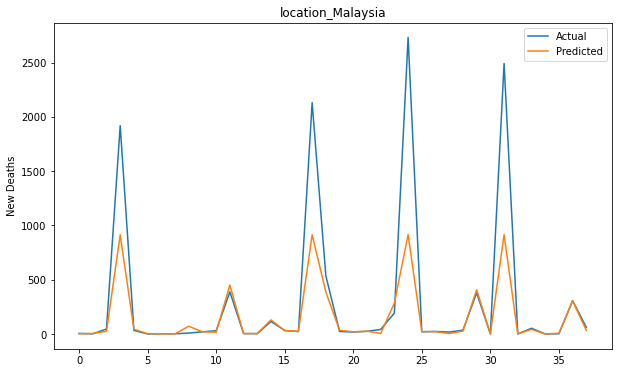

In [71]:
for country_name in ['location_Belgium', 'location_Chile', 'location_Ireland', 'location_Israel', 'location_Italy',
 'location_United States', 'location_Czechia', 'location_Estonia', 'location_France', 'location_Malaysia']:
    country_data = df[df[country_name] == 1]
    country_data = normalize(country_data)
    sequences = []
    targets = []
    sequence_length = 13

    for i in range(len(country_data) - sequence_length):
        sequences.append(country_data['new_deaths'].values[i:i+sequence_length])
        targets.append(country_data['new_deaths'].values[i+sequence_length])
    
    sequences = np.array(sequences)
    targets = np.array(targets)
    
    # Training and testing sets
    country_X_train, country_X_test, country_y_train, country_y_test = train_test_split(sequences, targets, test_size=0.2, random_state=42)

    # test predictions
    test_pred = model.predict(country_X_test.reshape((-1, sequence_length, 1)))

    plt.figure(figsize=(10, 6))
    plt.plot(country_y_test, label='Actual')
    plt.plot(test_pred, label='Predicted')
    plt.ylabel('New Deaths')
    plt.title(country_name)
    plt.legend()
    plt.show()

    mae = mean_absolute_error(test_pred, country_y_test)
    mase = MeanAbsoluteScaledError(sp = 13)
    mase = mase(test_pred, country_y_test, y_train = y_train)
    new_row = {'country': country_name, 'model': '5', 'mae': mae, 'mase': mase}
    metrics = metrics.append(new_row, ignore_index=True)

# Results

In [81]:
model1_metrics = metrics[metrics['model'] == '1']
model1_metrics.sort_values('mase')

country model          mae      mase
13        location_Estonia     1     6.338194  0.004428
3         location_Ireland     1     8.461096  0.005911
8         location_Ireland     1     8.461096  0.005911
4          location_Israel     1    11.506892  0.008039
9          location_Israel     1    11.506892  0.008039
0                  Belgium     1    29.303151  0.020471
1         location_Belgium     1    29.303151  0.020471
6         location_Belgium     1    29.303151  0.020471
2           location_Chile     1    51.271628  0.035818
7           location_Chile     1    51.271628  0.035818
12        location_Czechia     1    62.525612   0.04368
15       location_Malaysia     1   168.002005  0.117364
14         location_France     1     306.4445  0.214078
5           location_Italy     1   313.700358  0.219147
10          location_Italy     1   313.700358  0.219147
11  location_United States     1  3764.453176  2.629802

In [82]:
print('MAE:', model1_metrics['mae'].mean())
print('MASE:', model1_metrics['mase'].mean())

MAE: 322.84705557321246
MASE: 0.22553708657758806


In [83]:
model2_metrics = metrics[metrics['model'] == '2']
model2_metrics.sort_values('mase')

country model          mae      mase
23        location_Estonia     2      6.95602  0.004859
18        location_Ireland     2     8.266551  0.005775
19         location_Israel     2    11.637292   0.00813
16        location_Belgium     2    26.803369  0.018725
17          location_Chile     2    33.788089  0.023604
22        location_Czechia     2    49.957994    0.0349
25       location_Malaysia     2   171.028447  0.119478
24         location_France     2   289.019086  0.201905
20          location_Italy     2    295.21923  0.206237
21  location_United States     2  3774.916954  2.637112

In [85]:
print('MAE:', model2_metrics['mae'].mean())
print('MASE:', model2_metrics['mase'].mean())

MAE: 466.7593033389042
MASE: 0.3260724593604619


In [86]:
model3_metrics = metrics[metrics['model'] == '3']
model3_metrics.sort_values('mase')

country model          mae      mase
33        location_Estonia     3     6.867363  0.004797
28        location_Ireland     3     8.202164   0.00573
29         location_Israel     3    12.631007  0.008824
26        location_Belgium     3    23.149988  0.016172
32        location_Czechia     3    40.438455   0.02825
27          location_Chile     3    51.411067  0.035915
35       location_Malaysia     3      144.935   0.10125
30          location_Italy     3   265.724974  0.185632
34         location_France     3   269.888041  0.188541
31  location_United States     3  3571.928121  2.495306

In [87]:
print('MAE:', model3_metrics['mae'].mean())
print('MASE:', model3_metrics['mase'].mean())

MAE: 439.5176179057674
MASE: 0.3070417441657882


In [88]:
model4_metrics = metrics[metrics['model'] == '4']
model4_metrics.sort_values('mase')

country model         mae      mase
43        location_Estonia     4    6.847162  0.004783
38        location_Ireland     4    8.101296  0.005659
39         location_Israel     4   12.735051  0.008897
36        location_Belgium     4   27.554983   0.01925
37          location_Chile     4   42.491182  0.029684
42        location_Czechia     4   48.498781  0.033881
45       location_Malaysia     4  167.714685  0.117163
40          location_Italy     4  286.125674  0.199884
44         location_France     4  287.935249  0.201148
41  location_United States     4  3735.54625  2.609608

In [89]:
print('MAE:', model4_metrics['mae'].mean())
print('MASE:', model4_metrics['mase'].mean())

MAE: 462.3550312418687
MASE: 0.3229956876194383


In [90]:
model5_metrics = metrics[metrics['model'] == '5']
model5_metrics.sort_values('mase')

country model          mae      mase
53        location_Estonia     5      7.02342  0.004906
48        location_Ireland     5     9.268939  0.006475
49         location_Israel     5    20.677806  0.014445
46        location_Belgium     5    36.931564    0.0258
47          location_Chile     5    61.393956  0.042889
52        location_Czechia     5    65.885493  0.046027
55       location_Malaysia     5   163.528113  0.114239
54         location_France     5   315.371883  0.220315
50          location_Italy     5   325.804038  0.227603
51  location_United States     5  3763.280676  2.628983

In [91]:
print('MAE:', model5_metrics['mae'].mean())
print('MASE:', model5_metrics['mase'].mean())

MAE: 476.9165887380901
MASE: 0.3331682172957546
